# imports and setup

In [1]:
%autocall 2

Automatic calling is: Full


In [2]:
import numpy as np
from IPython.display import display, IFrame, Image, HTML
import os
import csv
import glob

In [3]:
import matplotlib.pyplot as plt
from scipy import sparse

from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
from ipywidgets import VBox, HBox, FloatSlider, Output
import ipywidgets as widgets

In [4]:
%matplotlib -l

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'gtk4', 'wx', 'qt4', 'qt5', 'qt6', 'qt', 'osx', 'nbagg', 'webagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


In [5]:
%matplotlib widget

# vowelcharts and vowel PCA mode coefficients

Story, Brad H., Houri K. Vorperian, Kate Bunton, and Reid B. Durtschi. 2018. “An Age-Dependent Vocal Tract Model for Males and Females Based on Anatomic Measurements.” The Journal of the Acoustical Society of America 143 (5): 3079.

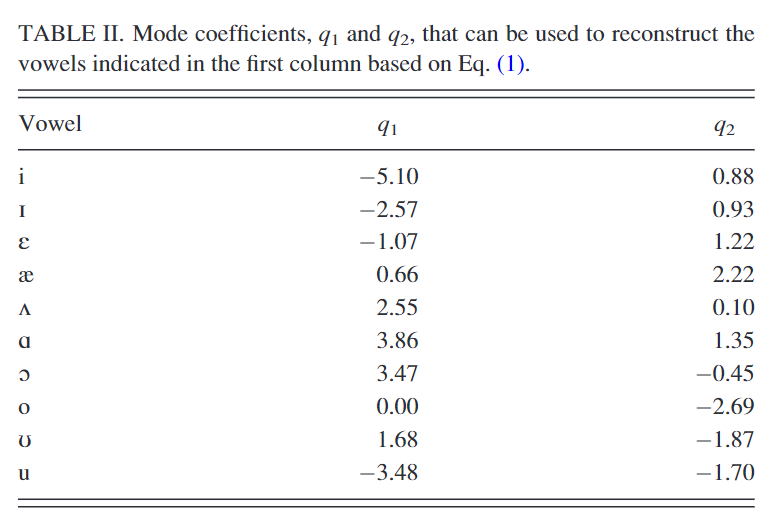

In [6]:
Image('voweltypes.png', width = 500)

In [7]:
vowelchart = {'ease': dict(place = ['front', 'close'], q1 = -5.1, q2 = 0.88), 
              'his': dict(place = ['front', 'close-mid-more'], q1 = -2.57, q2 = 0.93), 
              'then': dict(place = ['front', 'open-mid'], q1 = -1.07, q2 = 1.22), 
              'act': dict(place = ['front', 'open-more'], q1 = 0.66, q2 = 2.22),
              'must': dict(place = ['back', 'open-mid'], q1 = 2.55, q2 = 0.10), 
              'art': dict(place = ['back', 'open'], q1 = 3.86, q2 = 1.35),
              'aught': dict(place = ['back', 'open-mid'], q1 = 3.47, q2 = -0.45),
              'know': dict(place = ['back', 'close-mid'], q1 = 0.00, q2 = -2.69),
              'would': dict(place = ['back-central', 'close-mid-more'], q1 = 1.68, q2 = -1.87),
              'who': dict(place = ['back', 'close'], q1 = -3.48, q2 = -1.70)}

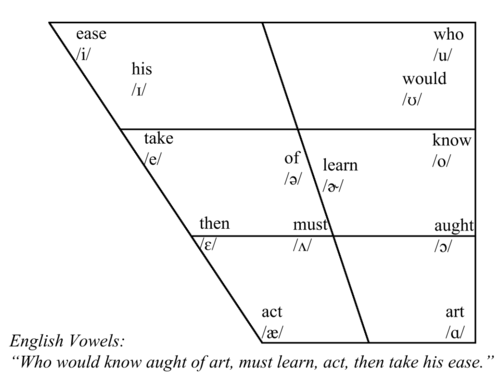

In [8]:
Image("EnglishVowels.png")

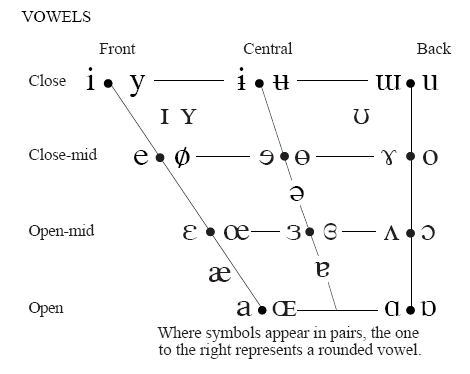

In [9]:
Image('https://www.internationalphoneticassociation.org/sites/default/files/vowels.gif')

# load Story data into vocaltracts dictionary

vocal tract area function from first two PCA modes: s = sex, a = age, v = vowel

$$A_x(s, a, v) = \pi/4 \left[ \Omega(s, a) + q_1(v) \phi_1(s, a) + q_2(v) \phi_2(s, a)\right]^2 $$

In [10]:
vocaltracts = dict(female = None, male = None)

datafiles = dict(female = 'Story2018data - Female.csv',
                 male = 'Story2018data - Male.csv')

for sex in datafiles.keys():
  with open(datafiles[sex]) as csvfile:
    csvreader = csv.reader(csvfile)

    ages = csvreader.__next__()
    annotations = csvreader.__next__()

    rows = []

    for row in csvreader:
      if row[0].isdigit():
        rows.append([float(e) for e in row[1:]])
      elif row[0].startswith('L(i)'):
        Li = [float(e) for e in row[1:] if e]
      elif row[0].startswith('VTL'):
        VTL = [float(e) for e in row[1:] if e]
        
  ages = [age.lower().replace(sex, '').strip() for age in ages if age]

  coeffs = np.array(rows).reshape(-1, len(Li), 3)

  vocaltracts[sex] = {age: dict(vowel = {vowel: None for vowel in vowelchart.keys()}) for age in ages}

  for num, age in enumerate(ages):
    o, p1, p2 = coeffs[:, num, :].T

    vocaltracts[sex][age].update(dict(li = Li[num], vtl = VTL[num]))

    for vowel in vowelchart.keys():
      Ax = np.pi / 4.0 * (o + vowelchart[vowel]['q1'] * p1 + vowelchart[vowel]['q2'] * p2)**2

      # vocaltracts[sex][age] = dict(o = o, p1 = p1, p2 = p2, li = Li[num], vtl = VTL[num], Ax = Ax)
      vocaltracts[sex][age]['vowel'][vowel] = Ax

# create plot of vowel area function

In [11]:
vowelselect = widgets.Dropdown(options = vowelchart.keys(), value = 'ease', description = 'vowel: ')
ageselect = widgets.Dropdown(options = ages, value = 'adult', description = 'age: ')
sexselect = widgets.Dropdown(options = vocaltracts.keys(), value = 'female', description = 'sex: ')

try:
  fig.clear()
  plt.close(fig)
  del fig
except:
  plt.close('all')

plt.ioff()
# plt.ion()

fig = plt.figure(figsize = (11, 5), clear = True)
fig.canvas.header_visible = False

ax = fig.add_subplot()

sex = 'female'
age = 'adult'

v1 = 'act'
NA = len(vocaltracts[sex][age]['vowel'][v1])
Li = vocaltracts[sex][age]['li']

line0 = ax.step(Li * np.arange(NA + 1), 
                np.sqrt(np.hstack((vocaltracts[sex][age]['vowel'][v1], 
                                   vocaltracts[sex][age]['vowel'][v1][-1:])) / np.pi),
                Li * np.arange(NA + 1), 
                - np.sqrt(np.hstack((vocaltracts[sex][age]['vowel'][v1], 
                                     vocaltracts[sex][age]['vowel'][v1][-1:])) / np.pi),
                where = 'post', color = 'b', label = f"{sex} {age}: {v1}")
line = ax.step(Li * np.arange(NA + 1), # + 20), 
               np.sqrt(np.hstack((vocaltracts[sex][age]['vowel']['ease'], 
                                  vocaltracts[sex][age]['vowel']['ease'][-1:], 
                                  # 20*[np.pi]
                                 )) / np.pi), 
               Li * np.arange(NA + 1), # + 20), 
               - np.sqrt(np.hstack((vocaltracts[sex][age]['vowel']['ease'], 
                                    vocaltracts[sex][age]['vowel']['ease'][-1:], 
                                    # 20*[np.pi]
                                   )) / np.pi),
               where = 'post', color = 'r', label = f"{sex} {age}: ease")


v2 = 'who'
line1 = ax.step(Li * np.arange(NA + 1), 
                np.sqrt(np.hstack((vocaltracts[sex][age]['vowel'][v2], 
                                   vocaltracts[sex][age]['vowel'][v2][-1:])) / np.pi),
                Li * np.arange(NA + 1), 
                - np.sqrt(np.hstack((vocaltracts[sex][age]['vowel'][v2], 
                                     vocaltracts[sex][age]['vowel'][v2][-1:])) / np.pi),
                where = 'post', color = 'g', label = f"{sex} {age}: {v2}")

plt.grid(which = 'both')

plt.xlabel('vocal tract location [cm]')
# plt.ylabel('area [$cm^2$]')
plt.ylabel('radius [cm]')

plt.xlim(left = 0)
# plt.ylim(bottom = 0)

# hide labels
line0[1].set_label('_')
line[1].set_label('_')
line1[1].set_label('_')

legend = ax.legend()

try:
    del updatefig
    del updatevowelplot
except:
    pass

def updatevowelplot(vowel, age, sex):
    NA = len(vocaltracts[sex][age]['vowel'][vowel])
    Li = vocaltracts[sex][age]['li']

    Nstraw = 20 * 0
    
    [l.set_xdata(Li * np.arange(NA + 1 + Nstraw)) for l in line]
    
    line[0].set_ydata(np.sqrt(np.hstack((vocaltracts[sex][age]['vowel'][vowel], 
                                         vocaltracts[sex][age]['vowel'][vowel][-1:], 
                                         Nstraw*[np.pi]
                                        )) / np.pi))
    line[1].set_ydata(- np.sqrt(np.hstack((vocaltracts[sex][age]['vowel'][vowel], 
                                           vocaltracts[sex][age]['vowel'][vowel][-1:], 
                                           Nstraw*[np.pi]
                                          )) / np.pi))
    
    [l.set_label(f"{sex} {age}: {vowel}") for l in line]
    line[1].set_label('_')

    ax.relim()
    ax.autoscale()
    ax.autoscale_view(scalex = True)

    ax.set_xlim(left = 0)
    # ax.set_ylim(bottom = 0)
    
    ax.legend()

    fig.canvas.draw()

updatefig = interactive_output(updatevowelplot, {'vowel': vowelselect, 'age': ageselect, 'sex': sexselect})

ui = HBox([sexselect, ageselect, vowelselect])

# Display vowel area function for different sexes, ages, and vowels

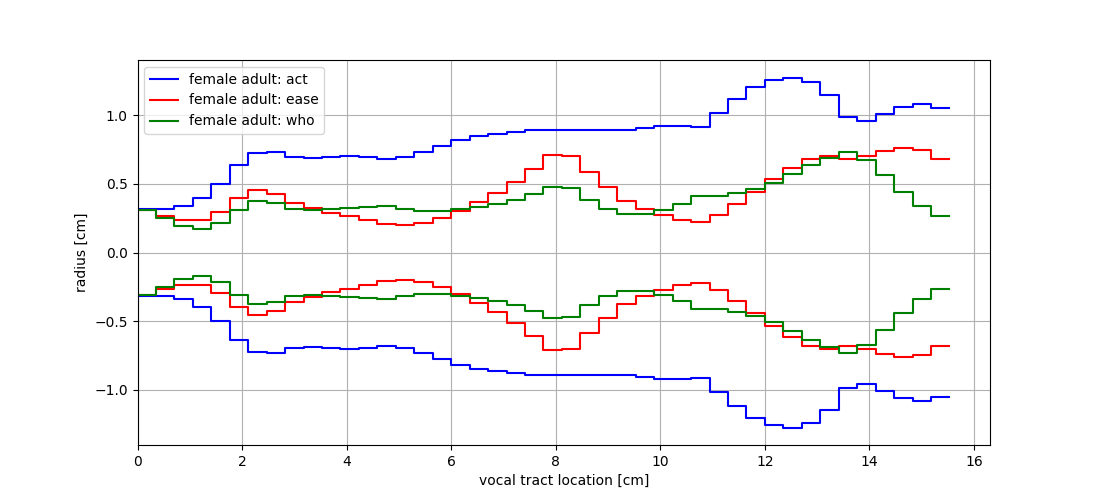

In [12]:
display(ui, fig.canvas)

# F0 ranges

In [13]:
f0rangesMike = {"infant": dict(female = [440, 590], male = [440, 590]),
                "3 yr": dict(female = [255, 360], male = [255, 360]), "4 yr": dict(female = [255, 360], male = [255, 360]),
                "8 yr": dict(female = [215, 300], male = [210, 295]),
                "12 yr": dict(female = [200, 280], male = [195, 275]), "15 yr": dict(female = [185, 260], male = [135, 205]),
                'adult': dict(female = [175, 245], male = [105, 160])}

f0meanMike = {a: {s: np.mean(f) for (s, f) in d.items()} for (a, d) in f0rangesMike.items()}
f0meanMike

{'infant': {'female': 515.0, 'male': 515.0},
 '3 yr': {'female': 307.5, 'male': 307.5},
 '4 yr': {'female': 307.5, 'male': 307.5},
 '8 yr': {'female': 257.5, 'male': 252.5},
 '12 yr': {'female': 240.0, 'male': 235.0},
 '15 yr': {'female': 222.5, 'male': 170.0},
 'adult': {'female': 210.0, 'male': 132.5}}

In [14]:
# Clinical Measurement of Speech and Voice - 2nd edition - Baken and Orlikoff
f0ranges = dict(newborn = dict(ageyear = [0, 1], f0 = [217, 435]),
                toddler = dict(ageyear = [1, 2], f0 = [305, 407]),
                preschool = dict(ageyear = [3, 5], f0 = [137, 322]),
                schoolage = dict(ageyear = [6, 12], f0 = [192, 271]),
                adolescent = dict(ageyear = [13, 17], f0 = []),
                adultfemale = dict(ageyear = [20, 85], f0 = [93, 275]),
                adultmale = dict(ageyear = [21, 85], f0 = [90, 178]),)
f0ranges

{'newborn': {'ageyear': [0, 1], 'f0': [217, 435]},
 'toddler': {'ageyear': [1, 2], 'f0': [305, 407]},
 'preschool': {'ageyear': [3, 5], 'f0': [137, 322]},
 'schoolage': {'ageyear': [6, 12], 'f0': [192, 271]},
 'adolescent': {'ageyear': [13, 17], 'f0': []},
 'adultfemale': {'ageyear': [20, 85], 'f0': [93, 275]},
 'adultmale': {'ageyear': [21, 85], 'f0': [90, 178]}}

In [15]:
ages

['adult', '12 yr', '8 yr', '4 yr', '0 yr']

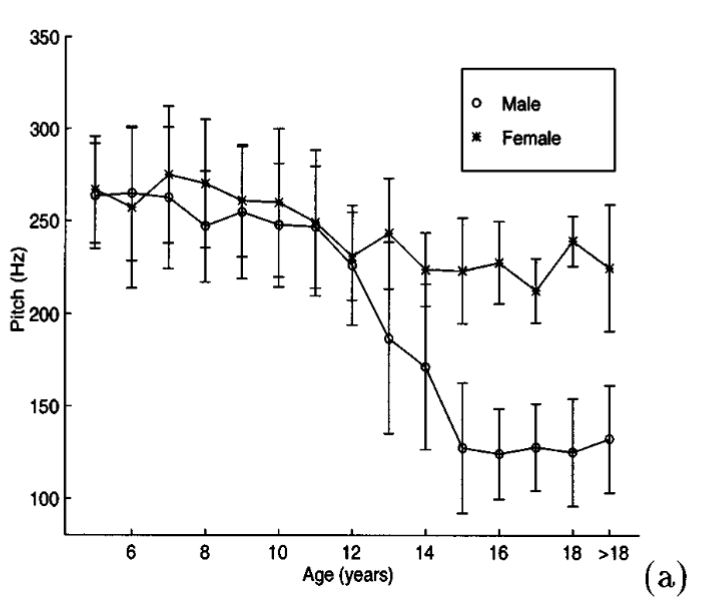

In [16]:
# Perry, T. L., R. N. Ohde, and D. H. Ashmead. 2001. 
# “The Acoustic Bases for Gender Identification from Children’s Voices.” 
# The Journal of the Acoustical Society of America 109 (6): 2988–98.

f0kids = dict(male = {'adult': 130,
                      '12 yr': 225, 
                      '8 yr': 260, 
                      '4 yr': 260,
                      '0 yr': 260},
              female = {'adult': 225,
                        '12 yr': 225, 
                        '8 yr': 260, 
                        '4 yr': 260,
                        '0 yr': 260})

Image('pitch-age.png', width = 500, height = 500)

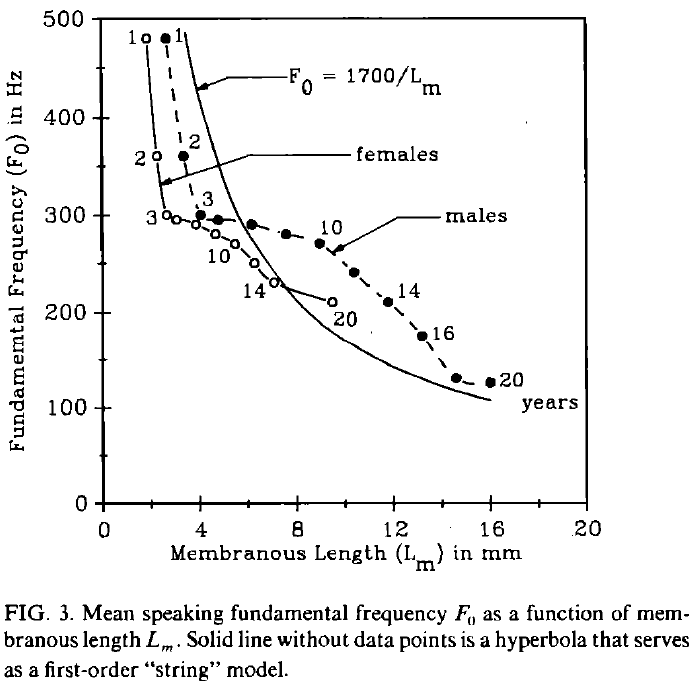

In [17]:
Image('pitch-Titze.png', width = 500, height = 500)

# paper: Wolfe, Fletcher, Smith: Interaction between wind instruments and their players

In [19]:
IFrame("Wind-Instrument-Overview.pdf", width = 1400, height = 600)

# paper: Story: Acoustic impedance of lengthened tract

In [19]:
IFrame("Story et al. 2000 - Acoustic impedance of an artificially lengthened and constricted vocal tract.pdf", width = 1400, height = 600)

# paper: Sondhi: speech synthesizer

In [20]:
IFrame("Sondhi and Schroeter 1987 - A hybrid time-frequency domain articulatory speech synthesizer.pdf", width = 1400, height = 600)

# Compute Impedances and Reflection

In [21]:
rho = 0.001225 # density of air in kg / cm^3
cair = 344 * 100 # speed of sound in cm/s, all lenghts are in cm

## K matrix

In [22]:
def compute_K(area_list, dL, fmin = 1, fmax = 1000, df = 1, hardwall = False, Kinitial = None, debug = False):

    if not hasattr(area_list, '__iter__'):
        print("Warning: compute_K: area_list must be an iterable, either list or 1D array")
    
    r = 130 * np.pi # rad/s
    Fw = 15 # Hertz
    Ft = 200 # Hertz
    q = 4 # rad/s
    
    Nf = 1 + int((fmax - fmin) / df)
    
    f_sparse = sparse.diags(np.linspace(fmin, fmax, num = Nf))
    w = 2 * np.pi * f_sparse
    
    invterm = sparse.eye(Nf, dtype = np.complex128)
    
    if not hardwall:
        r = r * sparse.eye(Nf)
        Fw = Fw * sparse.eye(Nf)

        alpha = np.sqrt(1j * w * q)

        invterm.setdiag(1 / ((1j * w + r) * 1j * w + (2 * np.pi * Fw)**2).data)
        beta = alpha + 1j * w * (2 * np.pi * Ft)**2 * invterm

        invterm.setdiag(1 / (beta + 1j * w).data)
        gamma = np.sqrt((r + 1j * w) * invterm)

        sigma = gamma * (beta + 1j * w)
    else:
        # hard walled tubes
        # r = 0, beta = 0, alpha = 0
        # gamma = 1
        # sigma = 1j * w
        
        r = 0
        beta = 0
        alpha = 0
        
        gamma = 1.0
        sigma = 1j * w
    
    # expm1(x) = exp(x) - 1
    # sinh(x) = 0.5 * [exp(x) - exp(-x)] = 0.5 * [expm1(x) - expm1[-x]]
    # cosh(x) = 0.5 * [exp(x) + exp(-x)] = 0.5 * [expm1(x) + expm1(-x) + 2]
    
    if type(dL) is not list:
        if debug: print("dL is not list")
        if not hasattr(dL, "__iter__"):
            if debug: print("dL has no __iter__")
            dL_list = [dL] * len(area_list)

            A = 0.5 * (np.expm1(sigma * dL / cair) + np.expm1(-sigma * dL / cair) + 2 * sparse.eye(Nf))
            D = A

            # sinhterm = np.sinh(sigma * dL / cair)
            sinhterm = 0.5 * (np.expm1(sigma * dL / cair) - np.expm1(-sigma * dL / cair))
        else:
            if debug: print("dL has __iter__")
            dL_list = dL
    elif type(dL) is list:
        if debug: print("dL is list")
        dL_list = dL
    elif hasattr(dL, "__iter__"):
        if debug: print("elif: dL has __iter__")
        dL_list = dL
    
    if Kinitial is None:
        # initialize K with identity matrix
        K = sparse.identity(2*Nf)
    else:
        # check that Kinitial has the same dimension!!!
        K = Kinitial
  
    if not hardwall:
        invterm.setdiag(1 / (rho * cair * gamma).data)
    else:
        invterm.setdiag(1.0 / (rho * cair * gamma))

    if hasattr(dL, "__iter__"):
        if debug: print("in loop: dL has __iter__")
        
        for Ax, dLx in zip(area_list, dL_list):
            A = 0.5 * (np.expm1(sigma * dLx / cair) + np.expm1(-sigma * dLx / cair) + 2 * sparse.eye(Nf))
            D = A
            # sinhterm = np.sinh(sigma * dLx / cair)
            sinhterm = 0.5 * (np.expm1(sigma * dLx / cair) - np.expm1(-sigma * dLx / cair))

            B = - rho * cair * gamma * sinhterm / Ax

            C = - Ax * sinhterm * invterm

            # multiply from right to left: K1, K2 * K1, K3 * K2 * K1, etc, to KN * KN-1 * ... K2 * K1
            K = sparse.bmat([[A, B], [C, D]]) @ K
    else:
        for Ax, dLx in zip(area_list, dL_list):
            B = - rho * cair * gamma * sinhterm / Ax

            C = - Ax * sinhterm * invterm

            # multiply from right to left: K1, K2 * K1, K3 * K2 * K1, etc, to KN * KN-1 * ... K2 * K1
            K = sparse.bmat([[A, B], [C, D]]) @ K
        
        
    return f_sparse, K

In [23]:
def compute_Ksidebranch(area_list, dL, Smain = None, fmin = 1, fmax = 1000, df = 1, hardwall = True, termination = "unflanged", debug = False):
    """
    terminationlist = ['unflanged', 'closed']
    """
    terminationlist = ['unflanged', 'closed']
    
    Nf = 1 + int((fmax - fmin) / df)
    
    if termination == 'unflanged':
        mouthradiation = 'unflanged'
    elif termination == 'closed':
        mouthradiation = 'closedmouth'
    else:
        print(f"WARNING: unknown termination: {termination}")
        print(f"possible termination conditions: {terminationlist}")
        print("using 'unflanged' instead")
        mouthtermination = 'unflanged'
    
    if debug:
        r = np.sqrt(area_list[0] / np.pi)
        L = dL
        Lprime = L + 1.4 * r
        
        if Smain:
            print("Smain = ", Smain) # area of main branch (main duct)
            print("cut-on frequency, -3dB point of transmission: f [Hz] = ", cair * r**2 / 4 / Smain / Lprime)
        else:
            print("need Smain, area of main branch, to calculate cut-on frequency")

    f_sparse, Zsidebranch, R, T, Ksidebranch = input_impedance(area_list, dL, fmin = fmin, fmax = fmax, df = df, hardwall = hardwall, mouthradiation = mouthradiation)
        
    invterm = sparse.eye(Nf, dtype = np.complex128)
    invterm.setdiag(1 / Zsidebranch.data)
    
    A = sparse.identity(Nf)
    B = sparse.identity(Nf) * 0.0
    
    C = - invterm
    D = sparse.identity(Nf)
    
    K = sparse.bmat([[A, B], [C, D]])
    
    return K

In [24]:
Smain = np.pi * 2.0**2 / 4.0

try:
    Ksidebranch = compute_Ksidebranch([np.pi * 0.5**2 / 4.0], 0.5 * 2, Smain = Smain, debug = True)
except:
    pass

Smain =  3.141592653589793
cut-on frequency, -3dB point of transmission: f [Hz] =  126.73449172132405


In [25]:
def compute_KHelmholtzResonator(Lneck = 1.0, rneck = 1.0, V = 10.0, R = 0, fmin = 1, fmax = 1000, df = 1, debug = False):
    """
    Lneck: length of neck in cm
    V: Volume of resonator in cm^3
    rneck: radius of neck in cm
    R: thermovisous losses, default: 0
    """
    Nf = 1 + int((fmax - fmin) / df)
    
    f_sparse = sparse.diags(np.linspace(fmin, fmax, num = Nf))
    w = 2 * np.pi * f_sparse

    # no thermoviscous losses by default
    Rb = R
    
    Sb = np.pi * rneck**2
    Lprime = Lneck + 1.7 * rneck
    
    L = rho * Lprime / Sb
    C = V / rho / cair**2
    
    invterm = sparse.eye(Nf, dtype = np.complex128)
    invterm.setdiag(np.squeeze(1 / (C * w).data))
    
    ZHelmholtz = Rb + 1j * ( w * L - invterm)
    
    # resonance frequency
    fresonance = cair * np.sqrt(Sb / Lprime / V) / 2 / np.pi
    
    if debug: 
        print("neck length Lneck [cm]: ", Lneck)
        print("neck radius r [cm]: ", rneck)
        print("resonator volume V [cm^3]: ", V)
        print("thermoviscous losses: ", R)
        print("Helmholtz resonator frequency = c/(2 Pi) * sqrt(Aneck / (Vcavity * Lprime)) [Hz]: ", fresonance)
    
    invterm.setdiag(1 / ZHelmholtz.data)
    
    A = sparse.identity(Nf)
    B = sparse.identity(Nf) * 0.0
    
    C = - invterm
    D = sparse.identity(Nf)
    
    K = sparse.bmat([[A, B], [C, D]])
    
    return K

## lip radiation impedance

$$b = \sqrt{\frac{A_{lips}}{\pi}} \\
Z_m = \frac{\rho c}{A_{lips}} \\
R = \frac{128 Z_m}{ 9 \pi^2} \\
L = \frac{8 b Z_m}{3 \pi c} \\
Z_{lips} = \frac{i \omega R L}{R + i \omega L}$$

In [26]:
def lip_impedance(area_lips, f_sparse):
    Nf = f_sparse.shape[0]
    
    invterm = sparse.eye(Nf, dtype = np.complex128)

    Amouth = area_lips 

    b = np.sqrt(Amouth / np.pi)
    Zm = rho * cair / Amouth

    R = 128 * Zm / (9 * np.pi**2)
    L = 8 * b * Zm / (3 * np.pi * cair)

    w = 2 * np.pi * f_sparse

    invterm.setdiag(np.squeeze(1 / (R * sparse.eye(Nf) + 1j * w * L).data))

    return (1j * w * R * L * invterm)

## input impedance

$$Z_{in} = \frac{D  Z_l - B}{A - C Z_l}$$

In [27]:
def input_impedance(area_list, dL, fmin = 1, fmax = 1000, df = 1, hardwall = False, mouthradiation = 'lips', Aglottis = None, Kinitial = None):
    """
    mouthradiationlist = ['lips', 'zero', 'infiniteduct', 'flanged', 'unflanged', 'closedmouth']
    """
    
    mouthradiationlist = ['lips', 'zero', 'infiniteduct', 'flanged', 'unflanged', 'closedmouth']
    mouthradiation = mouthradiation.lower().strip()
    
    f_sparse, K = compute_K(area_list, dL, fmin = fmin, fmax = fmax, df = df, hardwall = hardwall, Kinitial = Kinitial)
    
    Nf = f_sparse.shape[0]

    Atract = K[:Nf, :Nf]
    Btract = K[:Nf, Nf:]
    Ctract = K[Nf:, :Nf]
    Dtract = K[Nf:, Nf:]

    invterm = sparse.eye(Nf, dtype = np.complex128)
    
    Amouth = area_list[-1] # last entry in list of tublet areas
    
    w = 2 * np.pi * f_sparse
    k = w / cair

    # duct radius: a
    a = np.sqrt(Amouth / np.pi)
    
    if mouthradiation == 'lips':
        Zlips = lip_impedance(Amouth, f_sparse)
    elif mouthradiation == 'zero':
        Zlips = 0
    elif mouthradiation == 'closedmouth':
        Zlips = np.infty
    elif mouthradiation == 'infiniteduct':
        Zlips = rho * cair / Amouth
    elif mouthradiation == 'unflanged':
        Zlips = rho * cair / Amouth * (0.25 * (k * a)**2 + 1j * 0.61 * k * a)
    elif mouthradiation == 'flanged':
        Zlips = rho * cair / Amouth * (0.5 * (k * a)**2 + 1j * 8 / 3 / np.pi * k * a)
    else:
        print(f"WARNING: unknown mouthradiation: {mouthradiation}")
        print(f"possible mouthradiation conditions: {mouthradiationlist}")
        print("using 'lips' instead")
        Zlips = lip_impedance(Amouth, f_sparse)
        
    if Kinitial is None:
        S0 = area_list[0]
    else:
        S0 = Aglottis
    
    Z0 = rho * cair / S0
    
    Zout = Zlips
    
    # total length of duct
    if hasattr(dL, '__iter__'):
        Lt = np.sum(dL)
    else:
        Lt = dL * len(area_list)
        
    print(f"total length of duct: Lt = {Lt}")

    if mouthradiation == 'closedmouth':
        invterm.setdiag(1 / (Ctract).data)
        Zin_sparse = -Dtract * invterm
        
        invterm.setdiag(1 / (Dtract / Z0 - Ctract).data)
        R = (Dtract / Z0 + Ctract) * invterm

        # invterm.setdiag(1 / (Dtract / Z0 - Ctract).data)
        T = 2 * (np.expm1(-1j * k * Lt) + 1 * sparse.eye(Nf)) / Z0 * (Atract * Dtract - Btract * Ctract) * invterm
    else:
        invterm.setdiag(1 / (Atract - Ctract * Zlips).data)
        Zin_sparse = (Dtract * Zlips - Btract) * invterm

        invterm.setdiag(1 / (Dtract * Zout / Z0 - Btract / Z0 - Ctract * Zout + Atract).data)
        R = (Dtract * Zout / Z0 - Btract / Z0 + Ctract * Zout - Atract) * invterm

        # invterm.setdiag(1 / (Dtract * Zout / Z0 - Btract / Z0 - Ctract * Zout + Atract).data)
        T = 2 * (np.expm1(-1j * k * Lt) + 1 * sparse.eye(Nf)) * Zout / Z0 * (Atract * Dtract - Btract * Ctract) * invterm

    return f_sparse, Zin_sparse, R.diagonal(), T.diagonal(), K

## power reflection coefficient

Story worked with volume velocity, so the formula (like in Kinsler) needs to include the area S
$$
R = \frac{Z_{in} - \rho c/S}{Z_{in} + \rho c/S}
$$

Story and Sondhi:
$$ \begin{pmatrix}{p_{out} \\ Q_{out}}\end{pmatrix} = 
                                            \begin{bmatrix}
                                            A_t B_t \\
                                            C_t D_t
                                            \end{bmatrix} \begin{pmatrix}p_{in} \\ Q_{in}\end{pmatrix}$$

Does this make sense to you? Which impedances should be good to choose for $Z_0$ and $Z_{out}$???
$$
p_{in} = 1 + R ,\; Q_{in} = \frac{1 - R}{Z_0} \\
p_{out} = T \exp(i k L_t) ,\; Q_{out} = \frac{T \exp(i k L_t)}{Z_{out}} \\
Z_0 = \frac{\rho c}{S} \\
Z_{out} = Z_{lips} \\
k = \frac{2 \pi}{\lambda} = \frac{\omega}{c}
$$

after some rearrangements this is what I get for the reflection coefficient:

$$
R = \frac{D_t Z_{out} / Z_0 - B_t / Z_0 + C_t Z_{out} - A_t}{D_t Z_{out} / Z_0 - B_t / Z_0 - C_t Z_{out} + A_t}
$$

Note that the power transmission coefficient is not necessarily $T = 1 - R$ due to losses in the duct. Need to calculate $T$ from the set of equations
$$
T = 2 \exp(-i k L_t) \frac{Z_{out}}{Z_0} \frac{A_t D_t - B_t C_t}{D_t Z_{out}/Z_0 - B_t / Z_0 - C_t Z_{out} + A_t}
$$

The input impedance $Z_{in}$ will be:
$$
p_{in} = Z_{in} Q_{in} \\
p_{out} = Z_{out} Q_{out}
$$

$$
p_{in} = \frac{D_t Z_{out} - B_t}{A_t - C_t Z_{out}} Q_{in}
$$

That makes the reflection coefficient:
$$
R = \frac{Z_{in} - Z_0}{Z_{in} + Z_0}
$$

straight duct theory:
$$
\frac{Z_{in}}{Z_0} = \frac{Z_L/Z_0 + i \tan(k L)}{1 + i Z_L/Z_0 \tan(k L)}
$$
$$
R = \frac{(Z_L / Z_0 - 1) (\cos(k  L) - i  \sin(k L)) }{ (Z_{L} / Z_{0} + 1) (\cos(k L) + i \sin(k L))} = 
\frac{(Z_L / Z_0 - 1) (1 - i  \tan(k L)) }{ (Z_{L} / Z_{0} + 1) (1 + i \tan(k L))}
$$

In [28]:
IFrame("https://hal.science/hal-02366269/document", width = 1400, height = 600)

In [29]:
def powerreflectioncoeff(Zin_sparse, S, f_sparse):
    # power reflection and transmission coefficient
    Nf = f_sparse.shape[0]
    
    invterm = sparse.eye(Nf, dtype = np.complex128)
    invterm.setdiag(1 / (Zin_sparse + rho * cair / S * sparse.eye(Nf)).data)
    
    R = (Zin_sparse - rho * cair / S * sparse.eye(Nf)) * invterm 

    Rpower = np.abs(R.diagonal())**2

    # Tpower = 1 - Rpower
    
    return R.diagonal(), Rpower # , Tpower

# Resonator Selector widget setup

In [30]:
class Length(FloatSlider):
    def __init__(self, name, value, **kwargs):
        kwargs['description'] = name
        kwargs['value'] = value
        kwargs['min'] = 1
        kwargs['max'] = 100
        kwargs['step'] = 1
        kwargs['readout_format'] = '.1f'
        kwargs['continuous_update'] = False
        super().__init__(**kwargs)
    
    if False:
        def __repr__(self):
            return(f"{self.description} = {self.value}")
        
class Diameter(FloatSlider):
    def __init__(self, name, value, **kwargs):
        kwargs['description'] = name
        kwargs['value'] = value
        kwargs['min'] = 0.5
        kwargs['max'] = 10
        kwargs['step'] = 0.5
        kwargs['readout_format'] = '.1f'
        kwargs['continuous_update'] = False
        super().__init__(**kwargs)
    
    if False:
        def __repr__(self):
            return(f"{self.description} = {self.value}")

In [31]:
resonators = dict(nostraw = dict(sections = [dict()]),
                  
                  straight = dict(sections = [dict(L = Length('L [cm]', 100), D = Diameter('D [cm]', 2.5))]),
                  
                  lowpass = dict(sections = [dict(L = Length('L1 [cm]', 33), D = Diameter('D1 [cm]', 2.5)),
                                             dict(L = Length('L2 [cm]', 33), D = Diameter('D2 [cm]', 5.0)), 
                                             dict(L = Length('L3 [cm]', 33), D = Diameter('D3 [cm]', 2.5))]),
                  
                  highpass = dict(sections = [dict(L = Length('L1 [cm]', 50), D = Diameter('D1 [cm]', 2.5)),
                                              dict(L = Length('Lside [cm]', 1), D = Diameter('Dside [cm]', 2)),
                                              dict(L = Length('L2 [cm]', 50), D = Diameter('D2 [cm]', 2.5))]),
                  
                  bandstop = dict(sections = [dict(L = Length('L1 [cm]', 50), D = Diameter('D1 [cm]', 2.5)),
                                              dict(L = Length('Lneck [cm]', 5), D = Diameter('Dneck [cm]', 2)),
                                              dict(L = Length('Lcavity [cm]', 10), D = Diameter('Dcavity [cm]', 4)),
                                              dict(L = Length('L2 [cm]', 50), D = Diameter('D2 [cm]', 2.5))])) # in cm

In [32]:
# test
compute_K((np.pi/4 * np.array([s['D'].value for s in resonators['lowpass']['sections']])**2), 
          [s['L'].value for s in resonators['lowpass']['sections']], # lengths of sections as a list
          hardwall = True)

(<1000x1000 sparse matrix of type '<class 'numpy.float64'>'
 	with 1000 stored elements (1 diagonals) in DIAgonal format>,
 <2000x2000 sparse matrix of type '<class 'numpy.complex128'>'
 	with 4000 stored elements in Compressed Sparse Row format>)

In [33]:
config_nostraw = HBox()

config_straight = HBox([VBox(v) for v in [list(s.values()) for s in resonators['straight']['sections']]])

config_lowpass = HBox([VBox(v) for v in [list(s.values()) for s in resonators['lowpass']['sections']]])

config_highpass = HBox([VBox(v) for v in [list(s.values()) for s in resonators['highpass']['sections']]])

config_bandstop = HBox([VBox(v) for v in [list(s.values()) for s in resonators['bandstop']['sections']]])

config_resonators = [config_nostraw, config_straight, config_lowpass, config_highpass, config_bandstop]

resonatorstack = widgets.Stack(config_resonators, selected_index = 2)

select_resonator = widgets.Dropdown(options = resonators.keys(), value = 'lowpass', description = 'resonator')

widgets.jslink((select_resonator, 'index'), (resonatorstack, 'selected_index'))

config_resonator = widgets.VBox([select_resonator, resonatorstack])

In [34]:
out = widgets.Output()

@out.capture(clear_output = True, wait = True)
def update_resonator(change):
    print(change['new'])
    print(change['owner'].description)
    
select_resonator.observe(update_resonator, names = 'value')

In [35]:
for resonator in resonators.keys():
    for section in resonators[resonator]['sections']:
        for v in section.values():
            v.observe(update_resonator, names = 'value')

# Resonator Selector widget

In [36]:
display(config_resonator)
display(out)

Output()

# Calculate impedance functions for all cases

In [37]:
sex = 'male'
age = 'adult'
vowel = 'who'

dL = vocaltracts[sex][age]['li']

A = vocaltracts[sex][age]['vowel'][vowel]

f_sparse, Zin, R, T, K = input_impedance(A, dL)

f = f_sparse.diagonal()
Zvt = Zin.diagonal()

Amouth = A[-1] # last entry in list of tublet areas
Zlips = lip_impedance(Amouth, f_sparse).diagonal()

Aglottis = A[0]
# R, Rpower = powerreflectioncoeff(Zin, Aglottis, f_sparse)
Rpower = np.abs(R)**2
Tpower = np.abs(T)**2

display(K) # K.__repr__()
# print(K) # K.__str__()

total length of duct: Lt = 17.6


<2000x2000 sparse matrix of type '<class 'numpy.complex128'>'
	with 4000 stored elements in Compressed Sparse Row format>

In [38]:
def compute_acoustics(sex = 'female', age = 'adult', vowel = 'know'):
    pass

acoustics = dict(f = None)

for sex in vocaltracts.keys():
    acoustics.update({sex: dict()})
    
    for age in vocaltracts[sex].keys():
        acoustics[sex].update({age: dict()})
        
        for vowel in vocaltracts[sex][age]['vowel'].keys():
            dL = vocaltracts[sex][age]['li']
            Avowel = vocaltracts[sex][age]['vowel'][vowel]
            
            Aglottis = Avowel[0]
            Amouth = Avowel[-1]
            
            f_sparse, Zin, R, T, K = input_impedance(Avowel, dL, hardwall = False, mouthradiation = 'lips')

            Zlips = lip_impedance(Amouth, f_sparse).diagonal()
            
            f = f_sparse.diagonal()
            Zvt = Zin.diagonal()

            # R, Rpower = powerreflectioncoeff(Zin, Aglottis, f_sparse)
            Rpower = np.abs(R)**2
            Tpower = np.abs(T)**2

            # acoustics[sex][age].update({vowel: dict(Zvt = None, R = None, Rpower = None)})
            acoustics['f'] = f
            acoustics[sex][age][vowel] = dict(Zvt = Zvt, Zlips = Zlips, R = R, Rpower = Rpower, T = T, Tpower = Tpower, K = K)

total length of duct: Lt = 15.532
total length of duct: Lt = 15.532
total length of duct: Lt = 15.532
total length of duct: Lt = 15.532
total length of duct: Lt = 15.532
total length of duct: Lt = 15.532
total length of duct: Lt = 15.532
total length of duct: Lt = 15.532
total length of duct: Lt = 15.532
total length of duct: Lt = 15.532
total length of duct: Lt = 13.86
total length of duct: Lt = 13.86
total length of duct: Lt = 13.86
total length of duct: Lt = 13.86
total length of duct: Lt = 13.86
total length of duct: Lt = 13.86
total length of duct: Lt = 13.86
total length of duct: Lt = 13.86
total length of duct: Lt = 13.86
total length of duct: Lt = 13.86
total length of duct: Lt = 12.671999999999999
total length of duct: Lt = 12.671999999999999
total length of duct: Lt = 12.671999999999999
total length of duct: Lt = 12.671999999999999
total length of duct: Lt = 12.671999999999999
total length of duct: Lt = 12.671999999999999
total length of duct: Lt = 12.671999999999999
total le

In [39]:
acoustics.keys()

dict_keys(['f', 'female', 'male'])

In [40]:
acoustics[sex][age]['ease'].keys()

dict_keys(['Zvt', 'Zlips', 'R', 'Rpower', 'T', 'Tpower', 'K'])

In [41]:
print(sex, age, vowel)

acoustics[sex][age][vowel]['K']

male 0 yr who


<2000x2000 sparse matrix of type '<class 'numpy.complex128'>'
	with 4000 stored elements in Compressed Sparse Row format>

In [42]:
print(sex, age, vowel, Aglottis)

male 0 yr who 0.08622587639063303


In [43]:
Ltube = 33 * 2.54 # in cm
print("Ltube = ", Ltube)

Dtube = 1.0 # in cm

Dtube = 0.6 * 2.54 # diameter of 1/2 inch tube

Dtube = 0.8 * 2.54 # 3/4 inch tube ???

Dtube = 1.0

Atube = np.pi / 4.0 * Dtube**2

sex, age, vowel = ['male', 'adult', 'know']

# Atube = vocaltracts[sex][age]['vowel'][vowel][0]

print("Atube = ", Atube)
print("diameter of tube [cm]: ", np.sqrt(4 * Atube / np.pi))
print("diameter of tube [inches]: ", np.sqrt(4 * Atube / np.pi) / 2.54)

dLtube = Ltube
Atubelist = [Atube]

# f_sparse, Ktube = compute_K(Atubelist, dLtube, hardwall = True, Kinitial = None)

# f_sparse, Zin_total, R_total, T_total, K_total = input_impedance(Atubelist, dLtube, hardwall = True, mouthradiation = 'unflanged', Kinitial = acoustics[sex][age][vowel]['K'])

Ltube =  83.82000000000001
Atube =  0.7853981633974483
diameter of tube [cm]:  1.0
diameter of tube [inches]:  0.39370078740157477


# Impedance plots

## create impedances plots

In [44]:
try:
    figZ.clear()
    plt.close(figZ)
    del figZ
except:
    pass

figZ, axZ = plt.subplots(figsize = (11, 5), clear = True)
figZ.canvas.header_visible = False

sex = 'female'
age = 'adult'
vowel = 'ease'

sex, age, vowel = ['male', 'adult', 'would']

f = acoustics['f']
Zvt = acoustics[sex][age][vowel]['Zvt']
Zlips = acoustics[sex][age][vowel]['Zlips']

Aglottis = vocaltracts[sex][age]['vowel'][vowel][0]
print(sex, age, vowel, Aglottis)
Z0 = rho * cair / Aglottis

absZline, = axZ.plot(f, np.abs(Zvt) / Z0, label = '|Z| / Z0')

realZline, = axZ.plot(f, np.real(Zvt) / Z0, label = 'Resistance / Z0')
imagZline, = axZ.plot(f, np.imag(Zvt) / Z0, label = 'Reactance / Z0')


f_sparse, Zin_total, R_total, T_total, K_total = input_impedance(Atubelist, dLtube, hardwall = True, mouthradiation = 'unflanged', Aglottis = Aglottis, Kinitial = acoustics[sex][age][vowel]['K'])
Ztotal = Zin_total.diagonal()

absZtotalline, = axZ.plot(f, np.abs(Ztotal) / Z0, color = 'red', label = '|Ztotal| / Z0')

realZtotalline, = axZ.plot(f, np.real(Ztotal) / Z0, color = 'magenta', label = 'Resistance / Z0')
imagZtotalline, = axZ.plot(f, np.imag(Ztotal) / Z0, color = 'cyan', label = 'Reactance / Z0')

# axZ2 = axZ.twinx()
# absZlipsline, = axZ2.plot(f, np.abs(Zlips), 'o-', label = '|Zlips|')
# axZ2.set_ylabel('|Zlips|')

axZ.axhline(y = 0, color = 'k')
axZ.axhline(y = 1, color = 'k')

axZ.grid(which = 'both')
axZ.set_xlim(left = 0)

axZ.set_xlabel('frequency [Hz]')

axZ.set_title(f"{sex}: {age}: {vowel}: Aglottis = {Aglottis:.3f}")

axZ.legend()
# axZ2.legend()

figZ.sca(axZ)

figZ.canvas.draw()

male adult would 0.5040506594016378
total length of duct: Lt = 83.82000000000001


In [45]:
try:
    del updatefigZ
    del update_impedanceplot
except:
    pass

outZ = Output()

@outZ.capture(clear_output = True, wait = True)
def update_impedanceplot(vowel, age, sex):
    Zvt = acoustics[sex][age][vowel]['Zvt']
    Zlips = acoustics[sex][age][vowel]['Zlips']
    
    Aglottis = vocaltracts[sex][age]['vowel'][vowel][0]
    # print(sex, age, vowel, Aglottis)
    Z0 = rho * cair / Aglottis

    absZline.set_ydata(np.abs(Zvt) / Z0)
    realZline.set_ydata(np.real(Zvt) / Z0)
    imagZline.set_ydata(np.imag(Zvt) / Z0)
    
    axZ.set_title(f"{sex}: {age}: {vowel}: Aglottis = {Aglottis:.3f} cm^2")

    f_sparse, Zin_total, R_total, T_total, K_total = input_impedance(Atubelist, dLtube, hardwall = True, mouthradiation = 'unflanged', Aglottis = Aglottis, Kinitial = acoustics[sex][age][vowel]['K'])
    Ztotal = Zin_total.diagonal()
    
    absZtotalline.set_ydata(np.abs(Ztotal) / Z0)
    realZtotalline.set_ydata(np.real(Ztotal) / Z0)
    imagZtotalline.set_ydata(np.imag(Ztotal) / Z0)
    
    axZ.relim()
    # axZ2.relim()
    axZ.autoscale()
    # axZ2.autoscale()
    axZ.autoscale_view(scalex = True)
    
    axZ.set_xlim(left = 0)
    
    # axZ.legend()

    figZ.sca(axZ)
    
    figZ.canvas.draw()

updatefigZ = interactive_output(update_impedanceplot, {'vowel': vowelselect, 'age': ageselect, 'sex': sexselect})

uiZ = HBox([sexselect, ageselect, vowelselect])

## Display impedance plot

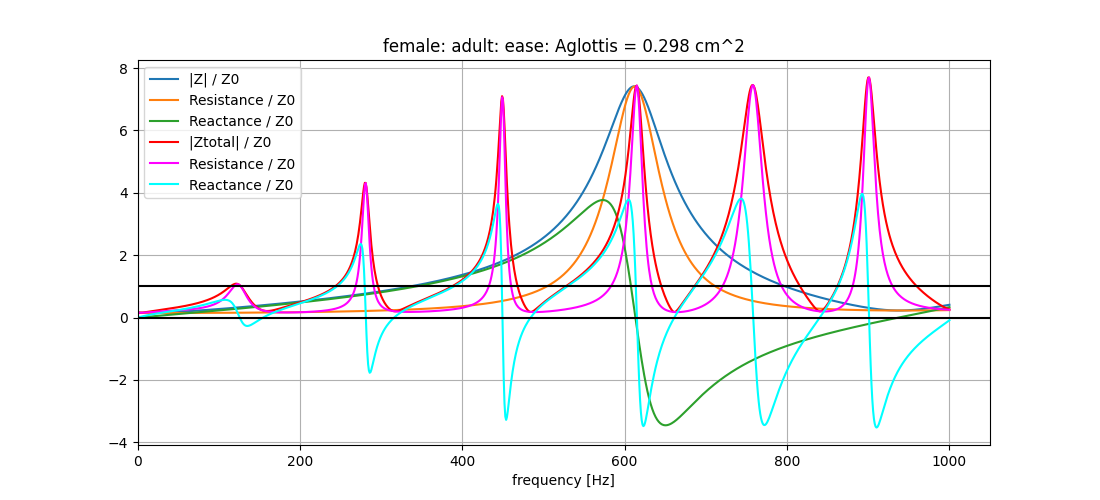

Output(outputs=({'name': 'stdout', 'text': 'total length of duct: Lt = 83.82000000000001\n', 'output_type': 's…

In [46]:
display(uiZ, figZ.canvas)
display(outZ)

# Reflection plots

In [47]:
def lowpassfilter(L1 = 20.0, L2 = 40.0, L3 = 20.0, D1 = 1.0, D2 = 1.0, D3 = 1.0, Kinitial = None, Aglottis = None, hardwall = True, termination = 'unflanged', debug = False):
    """
    Kinitial = acoustics[sex][age][vowel]['K']
    
    Ltube = 8.0 * 1.0
    
    Dtube = 0.5 * 1

    dLtube = [Ltube / 3 / 2, 
              Ltube / 3 * 10,
              Ltube / 3 / 2]

    Atubelist = [Atube, 
                 Atube * 4.0, 
                 Atube]
    """

    dLtube = [L1, L2, L3]
    
    Atubelist = [np.pi / 4.0 * D1**2, np.pi / 4.0 * D2**2, np.pi / 4.0 * D3**2]

    if debug:
        print("lowpassfilter: dLtube = ", dLtube)
        print("lowpassfilter: Atubelist = ", Atubelist)
        
        S = Atubelist[0]
        S1 = Atubelist[1]
        
        L = dLtube[1]
        
        try:
            print("lowpassfilter: cut-off frequency, -3dB point of transmission: f [Hz] = ", cair / np.pi / L * S / (S1 - S))
        except:
            pass
    
    f_sparse, Zin_total, R_total, T_total, K_total = input_impedance(Atubelist, dLtube, hardwall = hardwall, mouthradiation = termination, Aglottis = Aglottis, Kinitial = Kinitial)
    
    return f_sparse, Zin_total, R_total, T_total, K_total

In [48]:
# exponential horn
#
# TODO
#

In [49]:
Lt = 17

Dhalfinch = 2.54 * 0.622
Dthreequarterinch = 2.54 * 0.824

arealist = np.pi / 4.0 * np.array([Dhalfinch, Dhalfinch * np.sqrt(4), Dhalfinch])**2

if 0:
    f_sparse, Z_lowpass, R_lowpass, T_lowpass, K_lowpass = input_impedance(arealist, Lt / len(arealist), 
                                                                           hardwall = True, mouthradiation = 'unflanged', Aglottis = None, Kinitial = None)
else:
    f_sparse, Z_lowpass, R_lowpass, T_lowpass, K_lowpass = lowpassfilter(L1 = Lt / 3, L2 = Lt / 3, L3 = Lt / 3, 
                                                                         D1 = Dhalfinch, D2 = Dhalfinch * np.sqrt(4), D3 = Dhalfinch,
                                                                         hardwall = True, termination = 'unflanged', debug = True)

lowpassfilter: dLtube =  [5.666666666666667, 5.666666666666667, 5.666666666666667]
lowpassfilter: Atubelist =  [1.9603701634315631, 7.8414806537262525, 1.9603701634315631]
lowpassfilter: cut-off frequency, -3dB point of transmission: f [Hz] =  644.1094167483762
total length of duct: Lt = 17.0


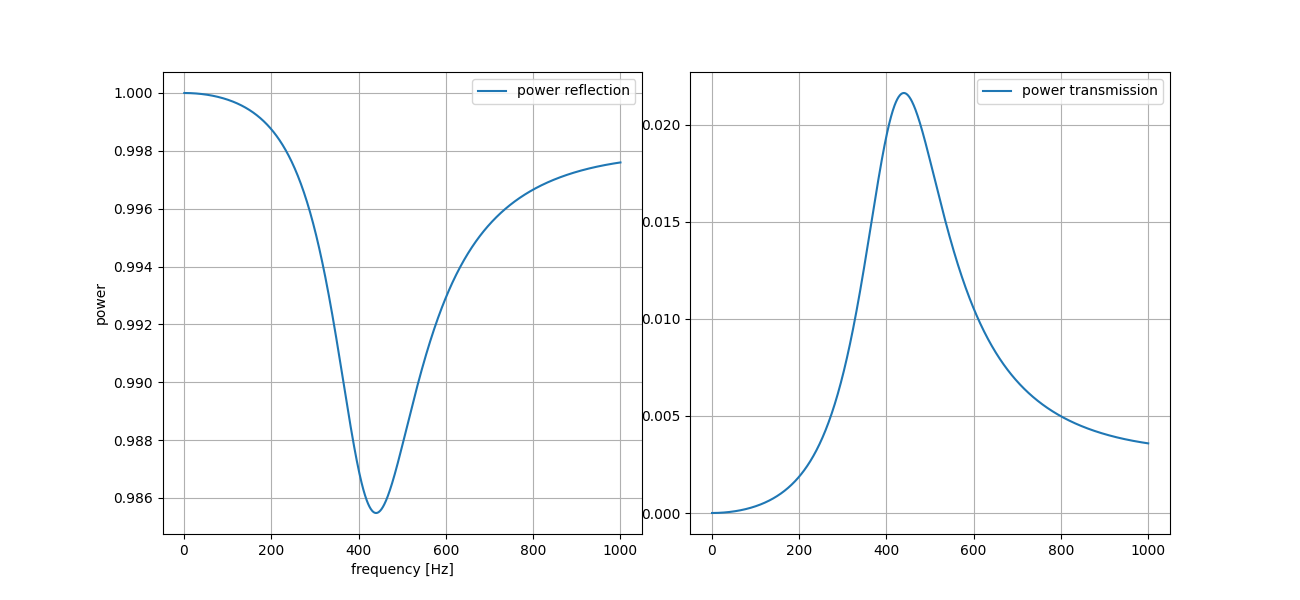

In [50]:
try:
    figtemp.clear()
    axtemp1.clear()
    axtemp2.clear()
    plt.close(figtemp)
    del axtemp1, axtemp2
    del figtemp
except:
    pass

figtemp, (axtemp1, axtemp2) = plt.subplots(ncols = 2, figsize = (13, 6), sharey = False, gridspec_kw = dict(wspace = 0.1))
figtemp.canvas.header_visible = False

axtemp1.plot(f_sparse.diagonal(), (np.abs(R_lowpass)**2), label = 'power reflection')
axtemp2.plot(f_sparse.diagonal(), (np.abs(T_lowpass)**2), label = 'power transmission')

axtemp1.set_xlabel('frequency [Hz]')
axtemp1.set_ylabel('power')

axtemp1.grid(visible = True, which = 'both')
axtemp2.grid(visible = True, which = 'both')

# axtemp1.set_ylim(top = 0)
# axtemp2.set_ylim(top = 0)

axtemp1.legend()
axtemp2.legend()

figtemp.canvas.draw()

display(figtemp.canvas)

In [51]:
def highpassfilter(L1 = 42, D1 = 2.0, L2 = 42, D2 = 2.0, 
                   Lneck = 0.5, Dneck = 2.0,
                   sidebranchfingerhole = 'closed',
                   Lcavity = None, Dcavity = None, 
                   Kinitial = None, Aglottis = None, hardwall = True, 
                   maintermination = 'unflanged', sidebranchtermination = 'unflanged', debug = False):
    """
    Kinitial = acoustics[sex][age][vowel]['K']
    """
    
    A1 = np.pi / 4.0 * D1**2
    A2 = np.pi / 4.0 * D2**2
    Aneck = np.pi / 4.0 * Dneck**2
    
    if Dcavity is not None and Lcavity is not None:
        Acavity = np.pi / 4.0 * Dcavity**2
        Asidebranchlist = [Aneck, Acavity]
        Lsidebranchlist = [Lneck, Lcavity]
    else:
        Asidebranchlist = [Aneck]
        Lsidebranchlist = Lneck

    if sidebranchfingerhole not in ['closed', 'open']:
        print("WARNING: unknown sidebranchfingerhole: ", sidebranchfingerhole)
        print("use 'closed' instead")
        sidebranchfingerhole = 'closed'

    if debug:
        print("highpassfilter: L1, D1, L2, D2 = ", [L1, D1, L2, D2])
        print("highpassfilter: Lneck, Dneck = ", [Lneck, Dneck])
        print("highpassfilter: sidebranchfingerhole: ", sidebranchfingerhole)
        print("highpassfilter: Lcavity, Dcavity = ", [Lcavity, Dcavity])
    
    f_sparse, Z1, R1, T1, K1 = input_impedance([A1], L1, hardwall = hardwall, mouthradiation = maintermination, Aglottis = Aglottis, Kinitial = Kinitial)

    if sidebranchfingerhole == 'closed':
        Ksidebranch = compute_Ksidebranch(Asidebranchlist, Lsidebranchlist, Smain = A1, termination = sidebranchtermination, debug = debug)
    else:
        f_sparse, Zsb1, Rsb1, Tsb1, Ksb1 = input_impedance(Asidebranchlist[0:1], Lsidebranchlist[0], hardwall = hardwall, mouthradiation = maintermination, Aglottis = Aglottis, Kinitial = None)

        Kfingerhole = compute_Ksidebranch(Asidebranchlist[0:1], Lsidebranchlist, Smain = A1, termination = sidebranchtermination, debug = debug)


    
    f_sparse, Z2, R2, T2, K2 = input_impedance([A2], L2, hardwall = hardwall, mouthradiation = maintermination, Aglottis = Aglottis, Kinitial = Ksidebranch @ K1)
    
    return f_sparse, Z2, R2, T2, K2

In [52]:
Ltotal = 84
L1 = Ltotal / 2

Dmain = Dthreequarterinch # Dhalfinch

f_sparse, Z_highpass, R_highpass, T_highpass, K_highpass = highpassfilter(L1 = L1, L2 = Ltotal - L1, D1 = Dthreequarterinch, D2 = Dthreequarterinch, 
                                                                          Lneck = 1.0, Dneck = Dthreequarterinch / 2,
                                                                          sidebranchfingerhole = 'closed',
                                                                          Lcavity = cair / 4.0 / 200, Dcavity = Dthreequarterinch * 2,
                                                                          Aglottis = np.pi / 4.0 * Dmain**2, 
                                                                          hardwall = True, 
                                                                          maintermination = 'infiniteduct', sidebranchtermination = 'closed',
                                                                          debug = True)

highpassfilter: L1, D1, L2, D2 =  [42.0, 2.0929599999999997, 42.0, 2.0929599999999997]
highpassfilter: Lneck, Dneck =  [1.0, 1.0464799999999999]
highpassfilter: sidebranchfingerhole:  closed
highpassfilter: Lcavity, Dcavity =  [43.0, 4.185919999999999]
total length of duct: Lt = 42.0
Smain =  3.4404221732770255
cut-on frequency, -3dB point of transmission: f [Hz] =  [395.00838961  15.64890395]
total length of duct: Lt = 44.0
total length of duct: Lt = 42.0


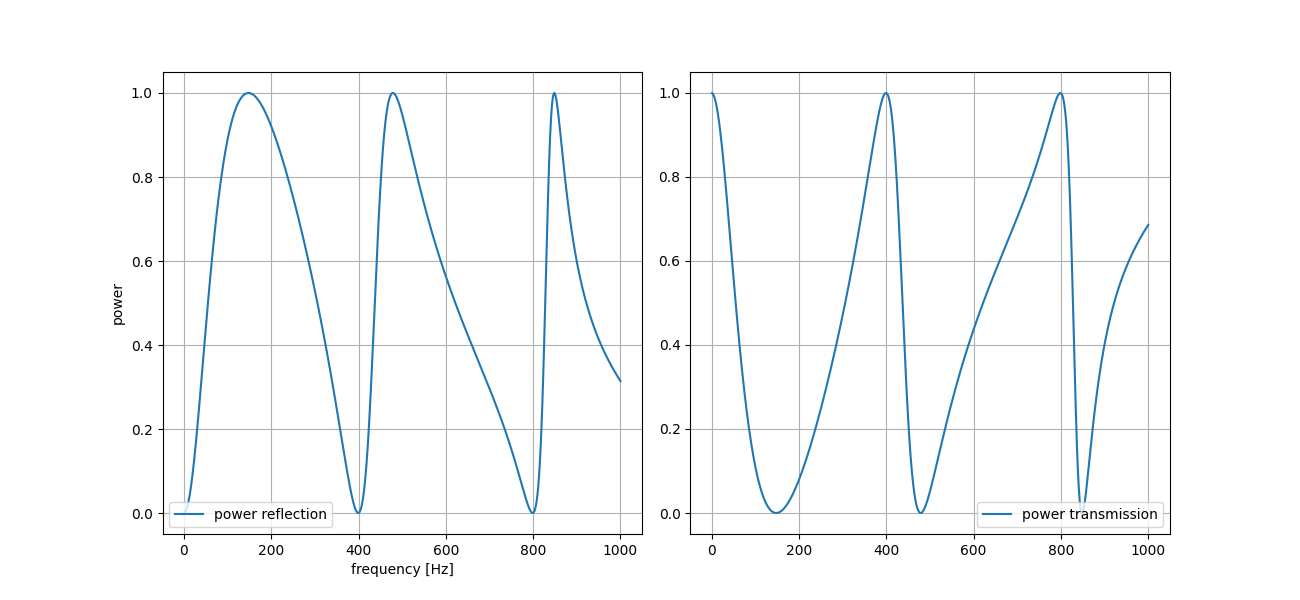

In [53]:
try:
    figtemp.clear()
    plt.close(figtemp)
    del figtemp
except:
    pass

figtemp, (axtemp1, axtemp2) = plt.subplots(ncols = 2, figsize = (13, 6), sharey = False, gridspec_kw = dict(wspace = 0.1))
figtemp.canvas.header_visible = False

axtemp1.plot(f_sparse.diagonal(), (np.abs(R_highpass)**2), label = 'power reflection')
axtemp2.plot(f_sparse.diagonal(), (np.abs(T_highpass)**2), label = 'power transmission')

axtemp1.set_xlabel('frequency [Hz]')
axtemp1.set_ylabel('power')

axtemp1.grid(visible = True, which = 'both')
axtemp2.grid(visible = True, which = 'both')

# axtemp1.set_ylim(top = 0)
# axtemp2.set_ylim(top = 0)

axtemp1.legend()
axtemp2.legend()

figtemp.canvas.draw()

display(figtemp.canvas)

In [54]:
def bandstopfilter(Lneck = 1.0, rneck = 1.0, V = 10.0, R = 0, L1 = 42, D1 = 2.0, L2 = 42, D2 = 2.0, Kinitial = None, Aglottis = None, hardwall = True, termination = 'unflanged', debug = False):
    """
    Lneck
    rneck
    V
    R
    L1
    L2
    D1
    D2
    """
    
    A1 = np.pi / 4.0 * D1**2
    A2 = np.pi / 4.0 * D2**2

    if debug:
        print("bandstopfilter: L1, L2 = ", [L1, L2])
        print("bandstopfilter: D1, D2 = ", [D1, D2])
        print("bandstopfilter: A1, A2 = ", [A1, A2])
    
    f_sparse, Z1, R1, T1, K1 = input_impedance([A1], L1, hardwall = hardwall, mouthradiation = termination, Aglottis = Aglottis, Kinitial = Kinitial)
    
    Khelmholtz = compute_KHelmholtzResonator(Lneck = Lneck, rneck = rneck, V = V, R = R, debug = debug)
    
    f_sparse, Z2, R2, T2, K2 = input_impedance([A2], L2, hardwall = hardwall, mouthradiation = termination, Aglottis = Aglottis, Kinitial = Khelmholtz @ K1)
    
    return f_sparse, Z2, R2, T2, K2

In [55]:
Ltotal = 84
L1 = Ltotal / 2

D1 = Dthreequarterinch # Dhalfinch
D2 = Dthreequarterinch

f_sparse, Z_bandstop, R_bandstop, T_bandstop, K_bandstop = bandstopfilter(Lneck = 1.0, rneck = 1.0 / 4, V = 100.0 * 4, R = 0,
                                                                          L1 = L1, D1 = D1, L2 = Ltotal - L1, D2 = D2, 
                                                                          Aglottis = np.pi / 4.0 * D1**2, 
                                                                          hardwall = True, 
                                                                          termination = 'infiniteduct', 
                                                                          debug = True)

bandstopfilter: L1, L2 =  [42.0, 42.0]
bandstopfilter: D1, D2 =  [2.0929599999999997, 2.0929599999999997]
bandstopfilter: A1, A2 =  [3.4404221732770255, 3.4404221732770255]
total length of duct: Lt = 42.0
neck length Lneck [cm]:  1.0
neck radius r [cm]:  0.25
resonator volume V [cm^3]:  400.0
thermoviscous losses:  0
Helmholtz resonator frequency = c/(2 Pi) * sqrt(Aneck / (Vcavity * Lprime)) [Hz]:  101.61459519716996
total length of duct: Lt = 42.0


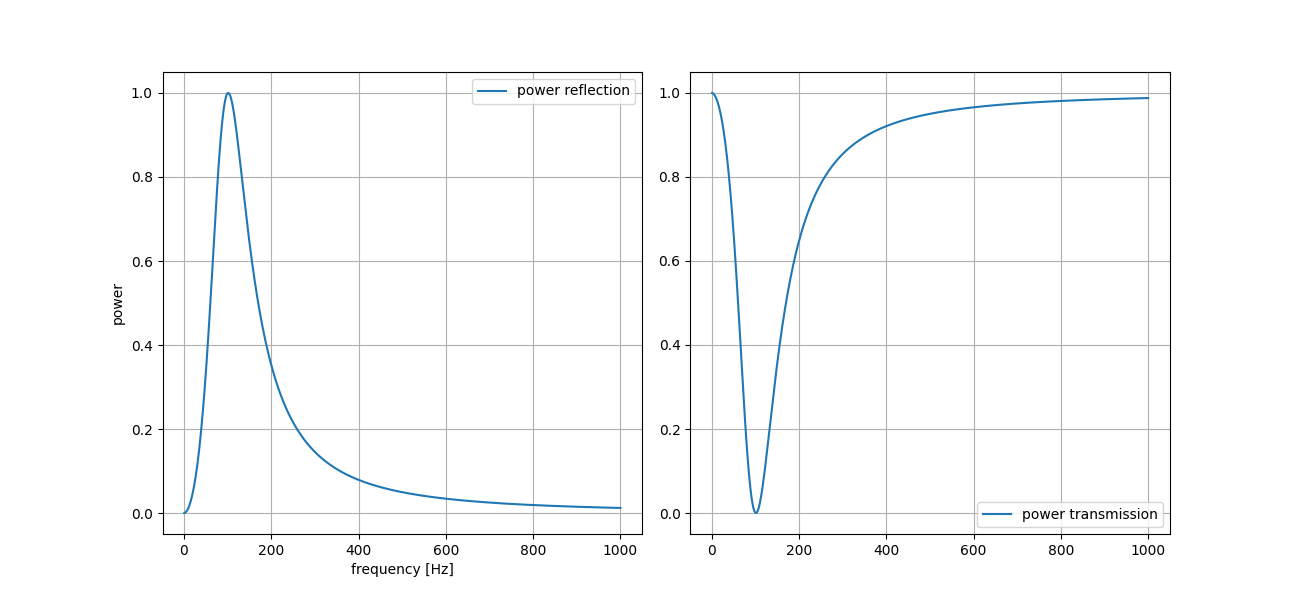

In [56]:
try:
    figtemp.clear()
    plt.close(figtemp)
    del figtemp
except:
    pass

figtemp, (axtemp1, axtemp2) = plt.subplots(ncols = 2, figsize = (13, 6), sharey = False, gridspec_kw = dict(wspace = 0.1))
figtemp.canvas.header_visible = False

axtemp1.plot(f_sparse.diagonal(), (np.abs(R_bandstop)**2), label = 'power reflection')
axtemp2.plot(f_sparse.diagonal(), (np.abs(T_bandstop)**2), label = 'power transmission')

axtemp1.set_xlabel('frequency [Hz]')
axtemp1.set_ylabel('power')

axtemp1.grid(visible = True, which = 'both')
axtemp2.grid(visible = True, which = 'both')

# axtemp1.set_ylim(top = 0)
# axtemp2.set_ylim(top = 0)

axtemp1.legend()
axtemp2.legend()

figtemp.canvas.draw()

display(figtemp.canvas)

## create reflection plot

In [60]:
try:
    figR.clear()
    plt.close(figR)
    del figR
except:
    pass

figR, ((axR, axQ), (axRtot, axQtot), (axRhigh, axQhigh)) = plt.subplots(nrows = 3, ncols = 2, figsize = (17, 6), sharex = True, sharey = True, clear = True,
                                                                        gridspec_kw = dict(left = 0.04, right = 0.96, bottom = 0.04, top = 0.96, wspace = 0.025, hspace = 0.125))
figR.canvas.header_visible = False

f = acoustics['f']
R = acoustics[sex][age][vowel]['R']
Rpower = acoustics[sex][age][vowel]['Rpower']
Tpower = acoustics[sex][age][vowel]['Tpower']

Aglottis = vocaltracts[sex][age]['vowel'][vowel][0]
Alips = vocaltracts[sex][age]['vowel'][vowel][-1]

###########################
absRline, = axR.plot(f, np.abs(R + 1) * 100, label = 'pi: 100 * |1 + R|') # should I plot and work with pi (1 + pr / pi)
angleRline, = axR.plot(f, np.angle(R + 1, deg = True), label = 'pi: angle(1 + R)')

R2line, = axR.plot(f, Rpower * 100, lw = 3, label = "power reflection [%]")
# T2line, = axR.plot(f, Tpower * 100, label = 'power transmission [percent]')

absUgline, = axQ.plot(f, np.abs((1 + R) / (1 - R)) * 100, label = 'Ug: 100 * |(1 + R)/(1 - R)|')
angleUgline, = axQ.plot(f, np.angle((1 + R) / (1 - R), deg = True), label = 'Ug: angle[(1 + R)/(1 - R)]')

###########################

# low-pass filter
if 0:
    f_sparse, Zin_total, R_total, T_total, K_total = lowpassfilter(L1 = Lt / 3, L2 = Lt / 3, L3 = Lt / 3, 
                                                                   D1 = Dhalfinch, D2 = Dhalfinch * np.sqrt(4), D3 = Dhalfinch,
                                                                   hardwall = True, termination = 'unflanged', debug = True,
                                                                   Aglottis = Aglottis, Kinitial = acoustics[sex][age][vowel]['K'])

# high-pass filter
if 0: # BROKEN
    f_sparse, Zin_total, R_total, T_total, K_total = highpassfilter(L1 = L1, L2 = Ltotal - L1, D1 = Dmain, D2 = Dmain,
                                                                    Lsidebranch = 0.5, # cair / 4.0 / 120, # 0.5,
                                                                    Dsidebranch = Dhalfinch * 0.5 * 2,
                                                                    hardwall = True, debug = True,
                                                                    maintermination = 'unflanged', sidebranchtermination = 'unflanged', # 'closed', # 'unflanged',
                                                                    Aglottis = Aglottis, Kinitial = acoustics[sex][age][vowel]['K'])
if 1:
    f_sparse, Zin_total, R_total, T_total, K_total = highpassfilter(L1 = L1, L2 = Ltotal - L1, D1 = Dmain, D2 = Dmain, 
                                                                              Lneck = 0.25, Dneck = Dhalfinch,
                                                                              sidebranchfingerhole = 'closed',
                                                                              Lcavity = 0.25, Dcavity = Dhalfinch,
                                                                              hardwall = True, debug = True,
                                                                              maintermination = 'unflanged', sidebranchtermination = 'unflanged',
                                                                              Aglottis = Aglottis, Kinitial = acoustics[sex][age][vowel]['K'])

Rpowertotal = np.abs(R_total)**2

absRtotline, = axRtot.plot(f, np.abs(R_total + 1) * 100, label = 'pi: 100 * |1 + Rtot|') # should I plot and work with pi (1 + pr / pi)
angleRtotline, = axRtot.plot(f, np.angle(R_total + 1, deg = True), label = 'pi: angle(1 + Rtot)')

R2totline, = axRtot.plot(f, Rpowertotal * 100, lw = 3, label = "SOVTE power reflection [%]")

absUgtotline, = axQtot.plot(f, np.abs((1 + R_total) / (1 - R_total)) * 100, label = 'Ug: 100 * |(1 + Rtot)/(1 - Rtot)|')
angleUgtotline, = axQtot.plot(f, np.angle((1 + R_total) / (1 - R_total), deg = True), label = 'Ug: angle[(1 + Rtot)/(1 - Rtot)]')
###########################

absRhighline, = axRhigh.plot(f, np.abs(R_total + 1) * 100, label = 'pi: 100 * |1 + Rtot|') # should I plot and work with pi (1 + pr / pi)
angleRhighline, = axRhigh.plot(f, np.angle(R_total + 1, deg = True), label = 'pi: angle(1 + Rtot)')

R2highline, = axRhigh.plot(f, Rpowertotal * 100, lw = 3, label = "SOVTE power reflection [%]")

absUghighline, = axQhigh.plot(f, np.abs((1 + R_total) / (1 - R_total)) * 100, label = 'Ug: 100 * |(1 + Rtot)/(1 - Rtot)|')
angleUghighline, = axQhigh.plot(f, np.angle((1 + R_total) / (1 - R_total), deg = True), label = 'Ug: angle[(1 + Rtot)/(1 - Rtot)]')

###########################
###########################

axR.set_title(f"{sex}: {age}: {vowel}")

f0mean = f0kids[sex][age]
(f1, f2) = f0rangesMike[age][sex]
f0mean = f0meanMike[age][sex]

for a in [axR, axRtot, axRhigh, axQ, axQtot, axQhigh]:
    a.axhline(y = 0, color = 'k')
    a.axhline(y = 100, color = 'k')

    a.set_xlim(left = 0)

    a.set_ylim(bottom = -50)
    a.set_ylim(top = 200)

    a.f0lines = [a.axvline(x = h * f0mean, color = 'r') for h in range(1, 10)]
    a.f0ranges = [a.axvspan(h*f1, h*f2, color = 'r', alpha = 0.25) for h in range(1, 2)]

    a.grid(visible = True, which = 'both')

    a.legend(loc = 'upper right')

for a in [axRhigh, axQhigh]:
    a.set_xlabel('frequency [Hz]')

figR.canvas.draw()

highpassfilter: L1, D1, L2, D2 =  [42.0, 2.0929599999999997, 42.0, 2.0929599999999997]
highpassfilter: Lneck, Dneck =  [0.25, 1.57988]
highpassfilter: sidebranchfingerhole:  closed
highpassfilter: Lcavity, Dcavity =  [0.25, 1.57988]
total length of duct: Lt = 42.0
Smain =  3.4404221732770255
cut-on frequency, -3dB point of transmission: f [Hz] =  [1150.38216248 1150.38216248]
total length of duct: Lt = 0.5
total length of duct: Lt = 42.0


In [66]:
try:
    del update_reflectionplot
    del updatefigR
except:
    pass

if 0:
    # lowpass
    Lt = 8 * 2.2
    L1 = Lt / 3 / 2
    L2 = Lt / 3 * 10
    L3 = Lt / 3 / 2
    
    Dt = 0.5 * 2
    D1 = Dt
    D2 = Dt * np.sqrt(4)
    D3 = Dt
    
    # highpass
    Ltotal = 84
    Lh1 = Ltotal / 2
    
    Dmain = Dthreequarterinch
    Dsidebranch = Dmain * 1.0

outR = Output()

@outR.capture(clear_output = True, wait = True)
def update_reflectionplot(vowel, age, sex, L1, L2, D1, D2, Lneck, Dneck, Lcavity, Dcavity, sidebranchtermination):
    R = acoustics[sex][age][vowel]['R']
    Rpower = acoustics[sex][age][vowel]['Rpower']
    Tpower = acoustics[sex][age][vowel]['Tpower']
    
    Aglottis = vocaltracts[sex][age]['vowel'][vowel][0]
    Alips = vocaltracts[sex][age]['vowel'][vowel][-1]
    
    ###########################
    
    absRline.set_ydata(np.abs(R + 1) * 100)
    angleRline.set_ydata(np.angle(R + 1, deg = True))

    absUgline.set_ydata(np.abs((1 + R) / (1 - R)) * 100)
    angleUgline.set_ydata(np.angle((1 + R) / (1 - R), deg = True))

    R2line.set_ydata(Rpower * 100)
    # T2line.set_ydata(Tpower * 100)

    ###########################
    # straight tube
    f_sparse, Z_tube, R_tube, T_tube, K_tube = input_impedance([np.pi / 4.0 * D1**2], L1 + L2, # Ltotal,
                                                               hardwall = True, mouthradiation = 'unflanged',
                                                               Aglottis = Aglottis, Kinitial = acoustics[sex][age][vowel]['K'])
    R = R_tube
    Rpower = np.abs(R)**2
    
    absRtotline.set_ydata(np.abs(R + 1) * 100)
    angleRtotline.set_ydata(np.angle(R + 1, deg = True))

    absUgtotline.set_ydata(np.abs((1 + R) / (1 - R)) * 100)
    angleUgtotline.set_ydata(np.angle((1 + R) / (1 - R), deg = True))

    R2totline.set_ydata(Rpower * 100)
    # T2line.set_ydata(Tpower * 100)
    
    ###########################
    ###########################
    # low-pass filter
    if 0:
        f_sparse, Zin_total, R_total, T_total, K_total = lowpassfilter(L1 = L1, L2 = L2, L3 = L3, 
                                                                       D1 = D1, D2 = D2, D3 = D3,
                                                                       hardwall = True, termination = 'unflanged', debug = True,
                                                                       Aglottis = Aglottis, Kinitial = acoustics[sex][age][vowel]['K'])

    ###########################
    # high-pass filter, could also be closed sidebranch, similar to Helmholtz resonator
    if 0:
        f_sparse, Zin_total, R_total, T_total, K_total = highpassfilter(L1 = L1, L2 = L2, Lsidebranch = LS, # cair / 4.0 / 200, # 0.5,
                                                                        Dmain = D1, Dsidebranch = D2,
                                                                        hardwall = True, debug = True,
                                                                        maintermination = 'unflanged', 
                                                                        sidebranchtermination = 'unflanged', # 'closed', # 'unflanged',
                                                                        Aglottis = Aglottis, Kinitial = acoustics[sex][age][vowel]['K'])
    if 0:
        f_sparse, Zin_total, R_total, T_total, K_total = highpassfilter(L1 = L1, L2 = L2, D1 = D1, D2 = D2, 
                                                                        Lsidebranch = Lneck, Dsidebranch = Dneck,
                                                                        Lcavity =  Lcavity, Dcavity = Dcavity,
                                                                        hardwall = True, debug = True,
                                                                        maintermination = 'unflanged', sidebranchtermination = sidebranchtermination,
                                                                        Aglottis = Aglottis, Kinitial = acoustics[sex][age][vowel]['K'])
    if 1:
        f_sparse, Zin_total, R_total, T_total, K_total = highpassfilter(L1 = L1, L2 = L2, D1 = D1, D2 = D2, 
                                                                                  Lneck = Lneck, Dneck = Dneck,
                                                                                  sidebranchfingerhole = 'closed',
                                                                                  Lcavity = Lcavity, Dcavity = Dcavity,
                                                                                  hardwall = True, debug = True,
                                                                                  maintermination = 'unflanged', sidebranchtermination = sidebranchtermination,
                                                                                  Aglottis = Aglottis, Kinitial = acoustics[sex][age][vowel]['K'])
    ###########################
    # bandstop filter, Helmholtz resonator, closed sidebranch with neck and cavity
    if 0:
        f_sparse, Zin_total, R_total, T_total, K_total = bandstopfilter(Lneck = Lneck, rneck = Dneck / 2, V = Lcavity * np.pi / 4.0 * Dcavity**2, R = 0,
                                                                        L1 = L1, D1 = D1, L2 = L2, D2 = D2,
                                                                        hardwall = True, debug = True,
                                                                        termination = 'unflanged', 
                                                                        Aglottis = Aglottis, Kinitial = acoustics[sex][age][vowel]['K'])
    ###########################
    ###########################
    Rpowertotal = np.abs(R_total)**2
    
    absRhighline.set_ydata(np.abs(R_total + 1) * 100)
    angleRhighline.set_ydata(np.angle(R_total + 1, deg = True))

    R2highline.set_ydata(Rpowertotal * 100)
    
    absUghighline.set_ydata(np.abs((1 + R_total) / (1 - R_total)) * 100)
    angleUghighline.set_ydata(np.angle((1 + R_total) / (1 - R_total), deg = True))

    ###########################
    
    axR.set_title(f"{sex}: {age}: {vowel}")
    axRtot.set_title(f"{sex}: {age}: {vowel} PLUS straight tube")
    axRhigh.set_title(f"{sex}: {age}: {vowel} PLUS straight tube PLUS sidebranch")
    
    f0mean = f0kids[sex][age]
    (f1, f2) = f0rangesMike[age][sex]
    f0mean = f0meanMike[age][sex]
    
    for a in [axR, axRtot, axRhigh, axQ, axQtot, axQhigh]:
        [a.f0lines[h-1].set_xdata(h * f0mean) for h in range(1, 10)]
        
        for num, af0 in enumerate(a.f0ranges):
            af0r = af0.get_xy()
            af0r[:, 0] = f1 * (num + 1)
            af0r[2:4, 0] = f2 * (num + 1)
            af0.set_xy(af0r)
        
        a.relim()
        a.autoscale()
        a.autoscale_view(scalex = True)

        a.set_xlim(left = 0)
        a.set_xlim(right = 1050)

        a.set_ylim(bottom = -50)
        a.set_ylim(top = 200)

        # axR.legend()

    figR.canvas.draw()

L1select = widgets.FloatSlider(value = 10, min = 0.5, max = 100, step = 0.5, description = 'L1 [cm]', continuous_update = True)
L2select = widgets.FloatSlider(value = 10, min = 0.5, max = 100, step = 0.5, description = 'L2 [cm]', continuous_update = True)

D1select = widgets.FloatSlider(value = 1, min = 0.1, max = 4, step = 0.1, description = 'D1 [cm]', continuous_update = True)
D2select = widgets.FloatSlider(value = 1, min = 0.1, max = 4, step = 0.1, description = 'D2 [cm]', continuous_update = True)

# highpass sidebranch length
Lneckselect = widgets.FloatSlider(value = 1, min = 0.1, max = 10, step = 0.1, description = 'Lneck [cm]', continuous_update = True)
Dneckselect = widgets.FloatSlider(value = 1, min = 0.1, max = 4, step = 0.1, description = 'Dneck [cm]', continuous_update = True)

Lcavityselect = widgets.FloatSlider(value = 1, min = 0.1, max = 100, step = 0.1, description = 'Lcavity [cm]', continuous_update = True)
Dcavityselect = widgets.FloatSlider(value = 1, min = 0.1, max = 10, step = 0.1, description = 'Dcavity [cm]', continuous_update = True)

SidebranchterminationSelect = widgets.ToggleButtons(value = "unflanged", options = ["unflanged", "closed"], description = "sidebranchtermination")
    
updatefigR = interactive_output(update_reflectionplot, {'vowel': vowelselect, 'age': ageselect, 'sex': sexselect, 
                                                        'L1': L1select, 'L2': L2select, 'D1': D1select, 'D2': D2select, 
                                                        'Lneck': Lneckselect, 'Dneck': Dneckselect, 
                                                        'Lcavity': Lcavityselect, 'Dcavity': Dcavityselect, 'sidebranchtermination': SidebranchterminationSelect})

uiR = VBox([HBox([sexselect, ageselect, vowelselect]), 
            HBox([L1select, L2select, D1select, D2select]), 
            HBox([Lneckselect, Dneckselect, Lcavityselect, Dcavityselect, SidebranchterminationSelect])])

## Display reflection plot

pressure $p_3$ acting on superior surface of vocal folds:
\begin{gather}
%$$
\tilde{p}_3(\omega) = \tilde{p}^+ \left[ 1 + \tilde{R}(\omega) \right]
\\
\tilde{p}_3(\omega) = \tilde{U}_g(\omega) \frac{\rho c}{A_1} \frac{1 + \tilde{R}(\omega)}{1 - \tilde{R}(\omega)}
%$$
\end{gather}

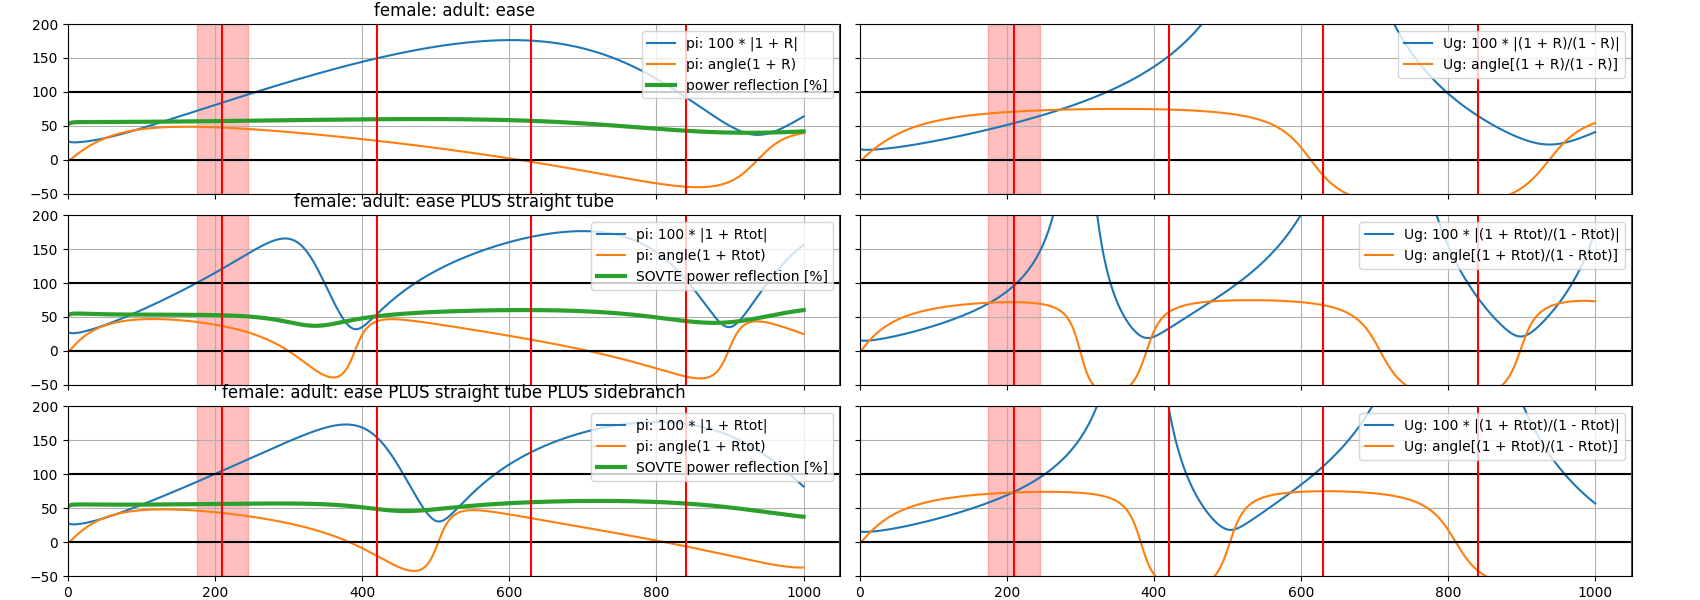

Output(outputs=({'name': 'stdout', 'text': 'total length of duct: Lt = 20.0\nhighpassfilter: L1, D1, L2, D2 = …

In [67]:
display(uiR, figR.canvas)
display(outR)

# plot reflection data across vowels or age

In [105]:
freqs = np.fft.fftfreq(10, d = 1/10)
freqs

array([ 0.,  1.,  2.,  3.,  4., -5., -4., -3., -2., -1.])

In [106]:
np.fft.fftshift(freqs)

array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])

In [107]:
np.fft.ifftshift(np.fft.fftshift(freqs))

array([ 0.,  1.,  2.,  3.,  4., -5., -4., -3., -2., -1.])

In [109]:
help(np.fft)

Help on package numpy.fft in numpy:

NAME
    numpy.fft

DESCRIPTION
    Discrete Fourier Transform (:mod:`numpy.fft`)
    
    .. currentmodule:: numpy.fft
    
    The SciPy module `scipy.fft` is a more comprehensive superset
    of ``numpy.fft``, which includes only a basic set of routines.
    
    Standard FFTs
    -------------
    
    .. autosummary::
       :toctree: generated/
    
       fft       Discrete Fourier transform.
       ifft      Inverse discrete Fourier transform.
       fft2      Discrete Fourier transform in two dimensions.
       ifft2     Inverse discrete Fourier transform in two dimensions.
       fftn      Discrete Fourier transform in N-dimensions.
       ifftn     Inverse discrete Fourier transform in N dimensions.
    
    Real FFTs
    ---------
    
    .. autosummary::
       :toctree: generated/
    
       rfft      Real discrete Fourier transform.
       irfft     Inverse real discrete Fourier transform.
       rfft2     Real discrete Fourier tran

In [60]:
f0kids

{'male': {'adult': 130, '12 yr': 225, '8 yr': 260, '4 yr': 260, '0 yr': 260},
 'female': {'adult': 225, '12 yr': 225, '8 yr': 260, '4 yr': 260, '0 yr': 260}}

In [61]:
f0ranges

{'newborn': {'ageyear': [0, 1], 'f0': [217, 435]},
 'toddler': {'ageyear': [1, 2], 'f0': [305, 407]},
 'preschool': {'ageyear': [3, 5], 'f0': [137, 322]},
 'schoolage': {'ageyear': [6, 12], 'f0': [192, 271]},
 'adolescent': {'ageyear': [13, 17], 'f0': []},
 'adultfemale': {'ageyear': [20, 85], 'f0': [93, 275]},
 'adultmale': {'ageyear': [21, 85], 'f0': [90, 178]}}

In [62]:
f0rangesMike

{'infant': {'female': [440, 590], 'male': [440, 590]},
 '3 yr': {'female': [255, 360], 'male': [255, 360]},
 '4 yr': {'female': [255, 360], 'male': [255, 360]},
 '8 yr': {'female': [215, 300], 'male': [210, 295]},
 '12 yr': {'female': [200, 280], 'male': [195, 275]},
 '15 yr': {'female': [185, 260], 'male': [135, 205]},
 'adult': {'female': [175, 245], 'male': [105, 160]}}

In [63]:
# axR.axvspan(90, 178, color = 'yellow')

In [64]:
display(HBox([sexselect, ageselect, vowelselect]))

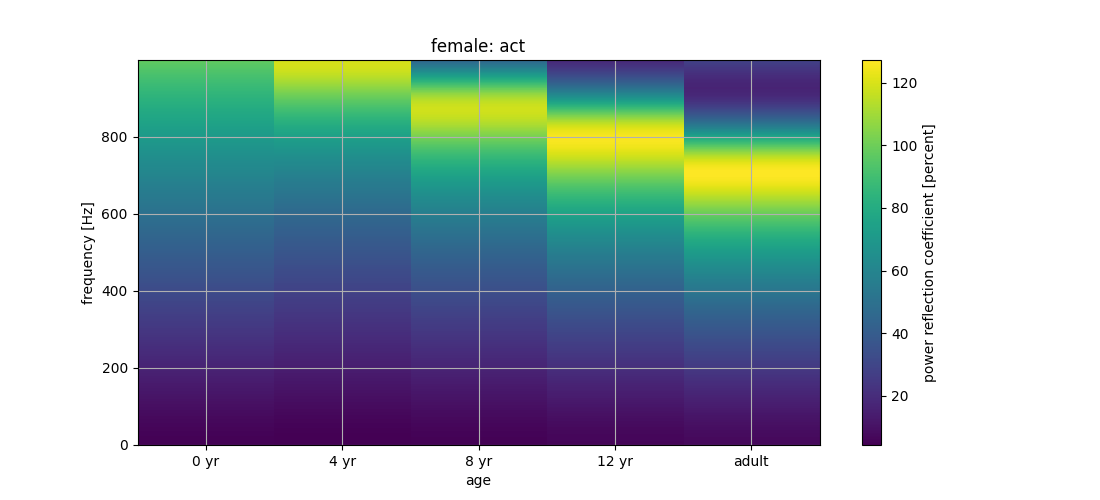

In [65]:
sex = sexselect.value
age = ageselect.value
vowel = vowelselect.value

try:
    plt.close(figIm)
except:
    pass

figIm, axIm = plt.subplots(figsize = (11, 5), clear = True)
figIm.canvas.header_visible = False

ageRpower = axIm.imshow(100 * np.abs(1 + np.flipud(np.array([acoustics[sex][a][vowel]['R'] for a in acoustics[sex].keys()]))).T, 
                        aspect = 'auto', origin = 'lower', interpolation = 'nearest')

axIm.grid(which = 'both')

axIm.set_xlabel('age')

agelabels = [a for a in acoustics[sex].keys()]
axIm.set_xticks(range(len(agelabels)), labels = agelabels[::-1])

axIm.set_ylabel('frequency [Hz]')

plt.colorbar(mappable = ageRpower, ax = axIm, location = 'right', label = 'power reflection coefficient [percent]')

axIm.set_title(f"{sex}: {vowel}")

figIm.canvas.draw()

display(figIm.canvas)

In [66]:
display(HBox([sexselect, ageselect, vowelselect]))

Ltotal:  100.0
total length of duct: Lt = 100.0
total length of duct: Lt = 60.0
total length of duct: Lt = 0.2
total length of duct: Lt = 40.0
total length of duct: Lt = 100.0
total length of duct: Lt = 60.0
total length of duct: Lt = 0.2
total length of duct: Lt = 40.0
total length of duct: Lt = 100.0
total length of duct: Lt = 60.0
total length of duct: Lt = 0.2
total length of duct: Lt = 40.0
total length of duct: Lt = 100.0
total length of duct: Lt = 60.0
total length of duct: Lt = 0.2
total length of duct: Lt = 40.0
total length of duct: Lt = 100.0
total length of duct: Lt = 60.0
total length of duct: Lt = 0.2
total length of duct: Lt = 40.0
total length of duct: Lt = 100.0
total length of duct: Lt = 60.0
total length of duct: Lt = 0.2
total length of duct: Lt = 40.0
total length of duct: Lt = 100.0
total length of duct: Lt = 60.0
total length of duct: Lt = 0.2
total length of duct: Lt = 40.0
total length of duct: Lt = 100.0
total length of duct: Lt = 60.0
total length of duct: Lt

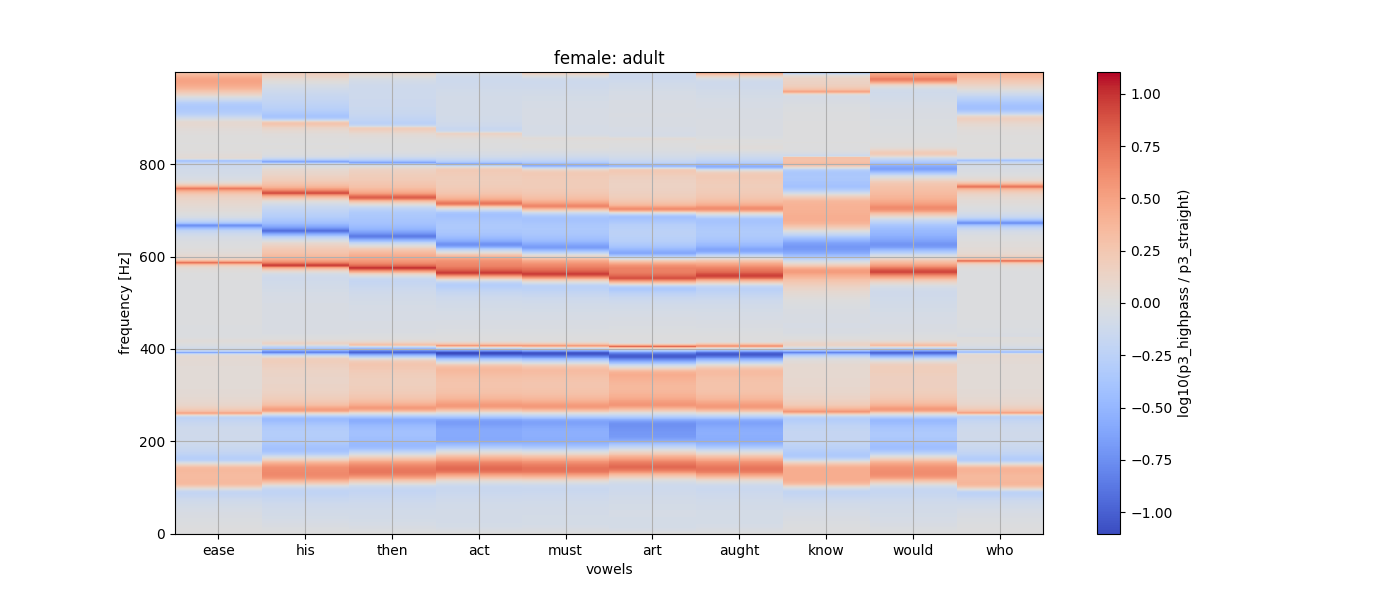

In [73]:
from matplotlib import colors as mplcolors

sex = sexselect.value
age = ageselect.value
vowel = vowelselect.value

L1 = L1select.value
L2 = L2select.value
D1 = D1select.value
D2 = D2select.value
Lneck = Lneckselect.value
Dneck = Dneckselect.value
Lcavity = Lcavityselect.value
Dcavity = Dcavityselect.value
sidebranchtermination = SidebranchterminationSelect.value

Ltotal = L1 + L2

print("Ltotal: ", Ltotal)

try:
    plt.close(figIm2)
    del figIm2, axIm2
except:
    pass

figIm2, axIm2 = plt.subplots(figsize = (14, 6), clear = True)
figIm2.canvas.header_visible = False

if 1:
    Rtube = []
    Rtot = []
    Rpower = []
    
    for v in acoustics[sex][age].keys():
        Aglottis = vocaltracts[sex][age]['vowel'][v][0]

        if 1:
            f_sparse, Z_tube, R_tube, T_tube, K_tube = input_impedance([np.pi / 4.0 * D1**2, np.pi / 4.0 * D2**2], [L1, L2],
                                                                       hardwall = True, mouthradiation = 'unflanged',
                                                                       Aglottis = Aglottis, Kinitial = acoustics[sex][age][v]['K'])
            Rtube.append(R_tube)
            # Rpower.append(np.abs(R_tube)**2)
        if 1:
            f_sparse, Zin_total, R_total, T_total, K_total = highpassfilter(L1 = L1, L2 = L2, D1 = D1, D2 = D2,
                                                                            Lsidebranch = Lneck, Dsidebranch = Dneck,
                                                                            Lcavity = Lcavity, Dcavity = Dcavity,
                                                                            hardwall = True, debug = False,
                                                                            maintermination = 'unflanged', 
                                                                            sidebranchtermination = sidebranchtermination, # 'closed', # 'unflanged',
                                                                            Aglottis = Aglottis, Kinitial = acoustics[sex][age][v]['K'])
            Rtot.append(R_total)
            # Rpower.append(np.abs(R_total)**2)

    vowelRpower = axIm2.imshow(np.log10(np.abs(1 + np.array(Rtot)).T / np.abs(1 + np.array(Rtube)).T),
                               # np.log10(np.abs(1 + np.array(Rtot)).T / np.abs(1 + np.array([acoustics[sex][age][v]['R'] for v in acoustics[sex][age].keys()])).T), 
                               aspect = 'auto', origin = 'lower', interpolation = 'nearest', norm = mplcolors.CenteredNorm(), cmap = 'coolwarm') # 'coolwarm') #'seismic')
else:
    vowelRpower = axIm2.imshow(100 * np.abs(1 + np.array([acoustics[sex][age][v]['R'] for v in acoustics[sex][age].keys()])).T, 
                               aspect = 'auto', origin = 'lower', interpolation = 'nearest')

axIm2.grid(which = 'both')

axIm2.set_xlabel('vowels')

vowellabels = [v for v in acoustics[sex][age].keys()]
axIm2.set_xticks(range(len(vowellabels)), labels = vowellabels)

axIm2.set_ylabel('frequency [Hz]')

plt.colorbar(mappable = vowelRpower, ax = axIm2, location = 'right', label = 'log10(p3_highpass / p3_straight)') # label = 'power reflection coefficient [percent]')

axIm2.set_title(f"{sex}: {age}")

figIm2.canvas.draw()

display(figIm2.canvas)

# calculate filter properties

## Russel: Acoustic Filters Lab

In [ ]:
IFrame("http://users.cms.caltech.edu/~ps/All.pdf", width = 1200, height = 600)

In [ ]:
display(config_resonator)
display(out)

print("predicted cut-off frequency (1/2 power, -3dB point): ???")

In [ ]:
resonators[select_resonator.value]['sections']

In [ ]:
dL_resonator = np.array([s['L'].value for s in resonators[select_resonator.value]['sections']])
print(dL_resonator)
D_resonator = np.array([s['D'].value for s in resonators[select_resonator.value]['sections']])
print(D_resonator)
A_resonator = np.pi / 4 * D_resonator**2 # in cm^2

In [ ]:
if False:
    # test case: open ended duct, no end correction: termination impedance 0, see Russel: Acoustic Filters Lab
    A_Russel = [2**2 * np.pi]
    dL_Russel = 101 # cm
    figZres_title = "Russel: Admittance 1/Z of straight duct"
     # "flanged", "unflanged"
    f_sparse_resonat, Zin_resonator, R_resonator, T_resonator = input_impedance(A_Russel, dL_Russel, df = 0.2, hardwall = True, mouthradiation = 'zero')

if True:
    # test case: Story paper: uniform tract, L = 17.5cm, area A = 3 cm^2
    A_Story = [3] * 2 + [30] * 96 + [3] * 2 # cm^2
    dL_Story = 100 / 100 # 17.5 # cm
    
    if type(dL_Story) is list:
        Ltotal = np.sum(dL_Story)
    else:
        Ltotal = dL_Story * len(A_Story)
    
    figZres_title = "Story: uniform tract, 17.5cm long, 3cm^2 area"
    hardwall = True
    mouthradiation = 'unflanged'
    figZres_title = f"duct, {len(A_Story)} sections, total: {Ltotal}cm long, cm^2, hard walls: {hardwall}, mouthradiation: {mouthradiation}"
    f_sparse_resonator, Zin_resonator, R_resonator, T_resonator = input_impedance(A_Story, dL_Story, df = 0.2,
                                                        hardwall = hardwall, 
                                                        mouthradiation = mouthradiation)
    # theory: straight duct
    Z0 = rho * cair / A_Story[0]
    k = 2 * np.pi * f_sparse_resonator.diagonal() / cair

    Zlips = lip_impedance(A_Story[-1], f_sparse_resonator).diagonal()
    Zlips = Z0

    # straight duct
    ZinTheory = Z0 * (Zlips / Z0 + 1j * np.tan(k * Ltotal)) / (1 + 1j * Zlips / Z0 * np.tan(k * Ltotal))

if False:
    # test case: low pass filter
    l1 = 10 # in units of dL_lowpass
    l2 = 150 * 2
    l3 = 10
    A_lowpass = [3]*l1 + [3 * 9]*l2 + [3]*l3 # cm^2 NOTE: concatenation of lists ;-)
    dL_lowpass = 0.1 # 17.5 # cm

    A_lowpass = [np.pi / 4 * 2**2, np.pi / 4 * 4**2, np.pi / 4 * 2**2]
    dL_lowpass = 33
    
    hardwall = False
    mouthradiation = 'lips' # for False: Zlips = 0: TOTAL REFLECTION!!!
    f_sparse_resonator, Zin_resonator, R_resonator, T_resonator = input_impedance(A_lowpass, dL_lowpass, df = 0.2,
                                                        hardwall = hardwall,
                                                        mouthradiation = mouthradiation)
    figZres_title = f"low-pass filter: hard walls: {hardwall}, mouthradiation: {mouthradiation}"

f_resonator = f_sparse_resonator.diagonal()
f = f_resonator

Z_resonator = Zin_resonator.diagonal()

try:
    plt.close(figZres)
except:
    pass

figZres, axZres = plt.subplots(figsize = (11, 5), clear = True)
figZres.canvas.header_visible = False

axZres.plot(f, (np.abs(Z_resonator)), label = '|Z|')

# axZres.plot(f, (np.abs(ZinTheory)), label = '|Ztheory|')

axZres.plot(f, np.real(Z_resonator), label = 'Resistance')
axZres.plot(f, np.imag(Z_resonator), label = 'Reactance')

axZres.grid(which = 'both')
axZres.set_xlim(left = 0, right = f[-1])
# axZres.set_ylim(bottom = 1)

axZres.set_xlabel('frequency [Hz]')

axZres.set_title(figZres_title) # (f"{select_resonator.value}")

axZres.legend()

figZres.canvas.draw()

In [ ]:
Aend = A_resonator[-1] # area for radiation

## filter impedance plot

In [ ]:
display(figZres.canvas)

In [ ]:
# Ainput = A_Story[0]
# R_resonator, Rpower_resonator = powerreflectioncoeff(Zin_resonator, Ainput, f_sparse_resonator)
Rpower_resonator = np.abs(R_resonator)**2

# power transmission: WRONG, need to directly calculate, could be different when there are losses in the soft wall!!!
Tpower_resonator = np.abs(T_resonator)**2

try:
    plt.close(figRes)
except:
    pass

figRes, axRes = plt.subplots(figsize = (11, 5), clear = True)
figRes.canvas.header_visible = False

# axRes.plot(f_resonator, np.abs(R_resonator) * 100, label = '100 * |R|') #, color = 'blue') # should I plot and work with pi (1 + pr / pi)

# axRes.plot(f_resonator, np.real(R_resonator), label = 'real(R)')
# axRes.plot(f_resonator, np.imag(R_resonator), label = 'imag(R)')

if False:
    ax2 = axRes.twinx()
    ax2.plot(f_resonator, np.angle(R_resonator, deg = True), color = 'cyan', label = 'angle(R)')

axRes.plot(f, Rpower_resonator * 100, label = 'power reflection [percent]') #, color = 'green')
axRes.plot(f, Tpower_resonator * 100, label = 'power transmission [percent]') #, color = 'green')

Zl = lip_impedance(A_Story[-1], f_sparse_resonator).diagonal()

Z0 = rho * cair / A_Story[0]
k = 2 * np.pi * f / cair

# straight tube
Rtheory = (Zl / Z0 - 1)*(np.cos(k * Ltotal) - 1j * np.sin(k * Ltotal)) / ( (Zl / Z0 + 1) * (np.cos(k * Ltotal) + 1j * np.sin(k * Ltotal)) )
# axRes.plot(f, np.abs(Rtheory)**2 * 100, label = 'theory: power reflection [percent]')

# axRes.axhline(color = 'k')
# axRes.axhline(y = 100, color = 'k')

axRes.set_xlim(left = 0, right = f[-1])
# axRes.set_ylim(bottom = -5, top = 105)

axRes.grid(visible = True, which = 'both')

axRes.set_xlabel('frequency [Hz]')

axRes.set_title(figZres_title) # f"{select_resonator.value}")

axRes.legend()

figRes.canvas.draw()

## power reflection and transmission plot

In [ ]:
display(figRes.canvas)

# Lous, Hirschberg 1998 paper

In [ ]:
IFrame("Lous et al. 1998 - A symmetrical two-mass vocal-fold model coupled to vocal tract and trachea, with application to prosthesis design.pdf", width = 1200, height = 500)

\begin{gather}
%$$
Z_1 = \rho c / A_1 
\\
Z_1 U_g(t) = p_1^+(t) - p_1^-(t)
\\
\text{Fourier transform: } \; Z_1 \tilde{U}_g(\omega) = \tilde{p}_1^+(\omega) - \tilde{p}_1^-(\omega)
\\
\text{reflection coefficient in Fourier space:} \; \tilde{R}(\omega) = \frac{\tilde{p}^-}{\tilde{p}^+}
\\
Z_1 \tilde{U}_g(\omega) = \tilde{p}^+ \left(1 - \tilde{R}\right)
%$$
\end{gather}

pressure $p_3$ acting on superior surface of vocal folds:
\begin{gather}
%$$
p_3(t) = p_{3, ac}(t) = p_1^+(t) + p_1^-(t)
\\
\text{Fourier transform: } \; \tilde{p}_3(\omega) = \tilde{p}^+ \left(1 + \tilde{R}(\omega)\right)
\\
\tilde{p}_3(\omega) = \tilde{U}_g(\omega) Z_1 \frac{1 + \tilde{R}(\omega)}{1 - \tilde{R}(\omega)} = \tilde{U}_g(\omega) \frac{\rho c}{A_1} \frac{1 + \tilde{R}(\omega)}{1 - \tilde{R}(\omega)}
%$$
\end{gather}

\begin{gather}
%$$
\tilde{p}_3(\omega) - Z_1 \tilde{U}_g(\omega) = \tilde{R}(\omega) \left( \tilde{p}_3(\omega) + Z_1 \tilde{U}_g(\omega) \right)
\\
\text{Inverse Fourier transform: } \; p_3(t) - Z_1 U_g(t) = R(t) * \left( p_3(t) + Z_1 U_g(t) \right) \text{with the convolution operation} \; f(t) * g(t) = \int{f(y) g(t)}
%$$
\end{gather}

no reflections $\tilde{R}(\omega) = 0 : \tilde{p}_3(\omega) = Z_1 \tilde{U}_g(\omega)$

infinite reflections $\tilde{R}(\omega) = \infty: \tilde{p}_3(\omega) = - Z_1 \tilde{U}_g(\omega)$

unity reflection $\tilde{R}(\omega) = 1: \tilde{p}_3(\omega) \to \infty$

modulus goes to one, phase free: $|\tilde{R}(\omega)| = 1 :$
$$
\tilde{p}_3(\omega) = Z_1 \tilde{U}_g(\omega) \frac{i \sin(\varphi)}{1 - \cos(\varphi)} = -i Z_1 \tilde{U}_g(\omega) \cot(\varphi / 2) = \exp(-i \pi / 2) Z_1 \tilde{U}_g(\omega) \cot(\varphi / 2)
$$

Large coupling of reflected pressure for small $A_1$, compared to what though? Compared to $\tilde{U}_g(\omega)$ and the fraction due to the reflection coefficient

$$
\tilde{R} = \frac{Z_{in} - Z_1}{Z_{in} + Z_1} \Rightarrow \frac{1 + \tilde{R}(\omega)}{1 - \tilde{R}(\omega)} = \frac{Z_{in}(\omega)}{Z_1}
$$

$$
\tilde{p}_3(\omega) = \tilde{U}_g(\omega) Z_{in}(\omega) = Z_1 \tilde{U}_g(\omega) + 2 \tilde{p}_1^-(\omega)
\\
\text{reflected pressure wave component: } \; \tilde{p}_1^-(\omega) = \frac{1}{2} \tilde{U}_g(\omega) \left(Z_{in} - Z_1\right)
$$

**ideal open end**, pressure node (zero), volume flow antinode: $Z_{L} = \frac{p_L}{U_L} = 0$

**closed end**, pressure antinode, volume flow node (zero): $Z_{L} = \infty$

for example: **straight duct theory:**
$$
\frac{Z_{in}}{Z_0} = \frac{Z_L/Z_0 + i \tan(k L)}{1 + i Z_L/Z_0 \tan(k L)}
\\
\tilde{R} = \frac{(Z_L / Z_0 - 1) (\cos(k  L) - i  \sin(k L)) }{ (Z_{L} / Z_{0} + 1) (\cos(k L) + i \sin(k L))} = 
\frac{(Z_L / Z_0 - 1) (1 - i  \tan(k L)) }{ (Z_{L} / Z_{0} + 1) (1 + i \tan(k L))}
$$

**open duct end** (no end correction, no radiation): $Z_{in} = Z_0 i \tan(k L)$, reflection coefficient: 
$$\tilde{R} = \frac{i  \tan(k L) - 1}{i \tan(k L) + 1} = - \exp(-i 2 k L) = - \exp(-i \omega \, 2 L / c) = - \exp(-i \omega \Delta T) = \exp\left[i (\pi - \omega \Delta T)\right] = - \cos(\omega \Delta T) + i \sin(\omega \Delta T)$$

with $\Delta T = \frac{2 L}{c}$ the total round-trip time from entrance to exit back to entrance of the duct

**closed duct end:** $Z_{in} = -i \cot(k L)$, reflection coefficient:
$$\tilde{R} = \frac{1 - i  \tan(k L)}{1 + i \tan(k L)} = \exp(-i 2 k L) = \exp(-i \omega \Delta T) = \cos(\omega \Delta T) - i \sin(\omega \Delta T)$$

open duct end (no end correction, no radiation): 
$$
\tilde{p}_3(\omega) = i Z_1 \tilde{U}_g(\omega) \tan(k L) = i Z_1 \tilde{U}_g \tan(\omega \, L/c) = i Z_1 \tilde{U}_g \tan(\omega \Delta T / 2) 
= Z_1 \tilde{U}_g \frac{i \sin(\omega \Delta T)}{\cos(\omega \Delta T) + 1}
$$ 

closed duct end: 
$$
\tilde{p}_3(\omega) = - i Z_1 \tilde{U}_g(\omega) \cot(k L) = - i Z_1 \tilde{U}_g(\omega) \cot(\omega \Delta T / 2) = Z_1 \tilde{U}_g \frac{i \sin(\omega \Delta T)}{\cos(\omega \Delta T) - 1}
$$

$$
\tilde{R}(\omega) = |\tilde{R}(\omega)| \exp(i \varphi(\omega))
$$

$$
\frac{1 + \tilde{R}(\omega)}{1 - \tilde{R}(\omega)} = \frac{1 - |\tilde{R}|^2 + 2 i |\tilde{R}| \sin(\varphi)}{1 + |\tilde{R}|^2 - 2 |\tilde{R}| \cos(\varphi)}
$$

$$
\varphi = 2 n \pi: \frac{1 + \tilde{R}(\omega)}{1 - \tilde{R}(\omega)} = \frac{1 + |\tilde{R}|}{1 - |\tilde{R}|} \; \text{MAXIMUM}
\\
\varphi = (n + 1) \pi: \frac{1 + \tilde{R}(\omega)}{1 - \tilde{R}(\omega)} = \frac{1 - |\tilde{R}|}{1 + |\tilde{R}|} \; \text{MINIMUM}
\\
\varphi = (n + 1) \pi/2: \frac{1 + \tilde{R}(\omega)}{1 - \tilde{R}(\omega)} = \frac{1 - |\tilde{R}|^2 \pm 2 i |\tilde{R}|}{1 + |\tilde{R}|^2}
$$

$$
\tilde{p}_3(\omega) = \tilde{U}_g(\omega) \frac{\rho c}{A_1} \frac{1 + \tilde{R}(\omega)}{1 - \tilde{R}(\omega)} = \tilde{U}_g(\omega) \frac{\rho c}{A_1} \frac{1 - |\tilde{R}|^2 + 2 i |\tilde{R}| \sin(\varphi)}{1 + |\tilde{R}|^2 - 2 |\tilde{R}| \cos(\varphi)}
$$

In [ ]:
f0ranges

In [ ]:
f0rangesMike

In [ ]:
Image("F0ranges.png")

In [ ]:
display(ui, fig.canvas)

In [ ]:
IFrame("McPhailSlides.pdf", width = 1200, height = 600)

In [ ]:
IFrame("https://en.wikibooks.org/wiki/Engineering_Acoustics/Noise_control_with_self-tuning_Helmholtz_resonators", width = 1600, height = 700)